# Skytrax Reviews — Project Abstract

This project analyzes Skytrax passenger reviews to identify the key drivers of customer satisfaction and translate them into actionable insights for airline operations. We combine exploratory analysis of service dimensions such as **staff quality**, **food and beverages**, **seat comfort**, and **ground service** with predictive modeling to classify passengers likely to recommend an airline and to estimate perceptions of value-for-money. By linking patterns in passenger experience to measurable outcomes, the study provides a ranked set of improvement levers, early indicators of at-risk experiences, and a reproducible modeling framework that can be adapted to airline decision-making.

In [600]:
# Imports

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    HistGradientBoostingClassifier, HistGradientBoostingRegressor
)

# Metrics
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, f1_score,
    mean_squared_error, r2_score, mean_absolute_error
)

# Distributions for hyperparameter tuning
from scipy.stats import randint, uniform

In [601]:
# Path setup (fix __file__ usage for Jupyter)
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, "../src"))
print("src_path:", src_path)
if src_path not in sys.path:
    sys.path.append(src_path)
print("sys.path:", sys.path)

#  Snowpark session
from connection import get_session
session = get_session()

# Data pull (limit for test, full for EDA)
df = session.table("FCT_REVIEW_ENRICHED").limit(5).to_pandas()
print(df.head())

src_path: /Users/tranmaiphuong/Documents/Airline Project/airline-analytics-project/src
sys.path: ['/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/tranmaiphuong/Documents/Airline Project/airline-analytics-project/.venv/lib/python3.12/site-packages', '/Users/tranmaiphuong/Documents/Airline Project/airline-analytics-project/src']
   REVIEW_ID  CUSTOMER_ID DATE_SUBMITTED_ID DATE_FLOWN_ID  ORIGIN_LOCATION_ID  \
0     115553        43364        2021-08-04    2021-08-01                3294   
1      98923        43373        2019-07-30    2019-07-01                2827   
2      77268        43377        2018-03-26    2018-03-01                3294   
3     131254        43383        2022-11-28    2022-11-01                2393   
4      97646        43387        2019-07-03    2019-06-01                4430   

### **Part 1: Data Exploration**

In [602]:
# Config variables 
FACT_TABLE = "FCT_REVIEW_ENRICHED"
NUMERIC_COLS = [
    "SEAT_COMFORT", "CABIN_STAFF_SERVICE", "FOOD_AND_BEVERAGES",
    "INFLIGHT_ENTERTAINMENT", "GROUND_SERVICE", "WIFI_AND_CONNECTIVITY",
    "VALUE_FOR_MONEY", "AVERAGE_RATING"
]
CATEGORICAL_COLS = [
    "SEAT_TYPE", "TYPE_OF_TRAVELLER", "RATING_BAND", "AIRLINE"
]
TARGET_COL = "RECOMMENDED"
TARGET_REG = "VALUE_FOR_MONEY"
ID_COLS = [
    "REVIEW_ID", "CUSTOMER_ID", "DATE_SUBMITTED_ID", "DATE_FLOWN_ID",
    "ORIGIN_LOCATION_ID", "DESTINATION_LOCATION_ID", "TRANSIT_LOCATION_ID", "AIRCRAFT_ID"
]

In [603]:
# Data shape checks
df_full = session.table(FACT_TABLE)
row_count = df_full.count()
print("Row count:", row_count)
cols = df_full.columns
print("Column count:", len(cols))


Row count: 121821
Column count: 25


We extract only the numeric ratings, categorical features, and target variable into a Pandas DataFrame for easier exploratory analysis and visualization.

In [604]:
# EDA sample
pdf_sample = df_full.select(*(NUMERIC_COLS + CATEGORICAL_COLS + [TARGET_COL])).to_pandas()
print(pdf_sample.shape)
print(pdf_sample.head())

(121821, 13)
   SEAT_COMFORT  CABIN_STAFF_SERVICE  FOOD_AND_BEVERAGES  \
0           NaN                  NaN                 NaN   
1           4.0                  4.0                 3.0   
2           3.0                  2.0                 NaN   
3           2.0                  1.0                 1.0   
4           1.0                  1.0                 1.0   

   INFLIGHT_ENTERTAINMENT  GROUND_SERVICE  WIFI_AND_CONNECTIVITY  \
0                     NaN             1.0                    NaN   
1                     4.0             4.0                    NaN   
2                     NaN             2.0                    NaN   
3                     1.0             2.0                    NaN   
4                     NaN             1.0                    NaN   

   VALUE_FOR_MONEY  AVERAGE_RATING      SEAT_TYPE TYPE_OF_TRAVELLER  \
0              1.0            1.00  Economy Class    Couple Leisure   
1              4.0            3.83  Economy Class      Solo Leisure   
2   

### Missing Values Analysis

In [605]:
# Missing values analysis
missing_pct = pdf_sample.isna().mean().sort_values(ascending=False) * 100
missing_pct = missing_pct.round(2).to_frame("missing_%")
print(missing_pct)

                        missing_%
WIFI_AND_CONNECTIVITY       67.07
INFLIGHT_ENTERTAINMENT      44.07
FOOD_AND_BEVERAGES          29.75
CABIN_STAFF_SERVICE          7.33
GROUND_SERVICE               7.32
SEAT_COMFORT                 6.86
TYPE_OF_TRAVELLER            3.68
SEAT_TYPE                    0.21
VALUE_FOR_MONEY              0.01
AVERAGE_RATING               0.01
RATING_BAND                  0.00
AIRLINE                      0.00
RECOMMENDED                  0.00


- Major gaps: Wi-Fi (67%), Entertainment (44%), Food (30%).  
- Moderate gaps: Comfort, Staff, Ground (~7%).  
- Targets & Airline fields → fully populated.  
- Missingness is structured (e.g., Wi-Fi missing = service not offered).

### Target Balance

In [606]:
# Target normalization and balance
pdf_sample[TARGET_COL] = (
    pdf_sample[TARGET_COL].astype(str).str.lower().isin(["true", "1", "yes"])
).astype(int)
balance = pdf_sample[TARGET_COL].value_counts().rename(index={0:"Not Recommend", 1:"Recommend"})
print("RECOMMENDED counts:\n", balance)
print("\nRECOMMENDED balance (%):\n", (balance / balance.sum() * 100).round(2))
vfm_counts = pdf_sample["VALUE_FOR_MONEY"].value_counts().sort_index()
print("\nVALUE_FOR_MONEY counts:\n", vfm_counts)
print("\nVALUE_FOR_MONEY distribution (%):\n", (vfm_counts / vfm_counts.sum() * 100).round(2))


RECOMMENDED counts:
 RECOMMENDED
Not Recommend    82925
Recommend        38896
Name: count, dtype: int64

RECOMMENDED balance (%):
 RECOMMENDED
Not Recommend    68.07
Recommend        31.93
Name: count, dtype: float64

VALUE_FOR_MONEY counts:
 VALUE_FOR_MONEY
1.0    59145
2.0    14296
3.0    12455
4.0    14205
5.0    21705
Name: count, dtype: int64

VALUE_FOR_MONEY distribution (%):
 VALUE_FOR_MONEY
1.0    48.56
2.0    11.74
3.0    10.23
4.0    11.66
5.0    17.82
Name: count, dtype: float64


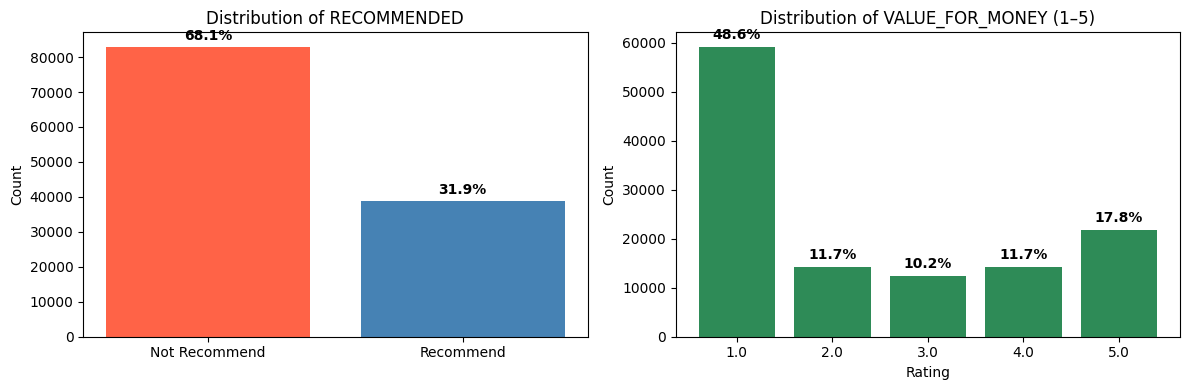

In [607]:
# Plotting (wrap in functions for testability)
def plot_target_distributions(pdf_sample, target_col, vfm_col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    counts = pdf_sample[target_col].value_counts().sort_index()
    bars = axes[0].bar(["Not Recommend", "Recommend"], counts, color=["tomato", "steelblue"])
    axes[0].set_title("Distribution of RECOMMENDED")
    axes[0].set_ylabel("Count")
    for bar, count in zip(bars, counts):
        pct = f"{count / counts.sum() * 100:.1f}%"
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1000,
                     pct, ha="center", va="bottom", fontsize=10, fontweight="bold")
    vfm_counts = pdf_sample[vfm_col].value_counts().sort_index()
    bars = axes[1].bar(vfm_counts.index.astype(str), vfm_counts.values, color="seagreen")
    axes[1].set_title("Distribution of VALUE_FOR_MONEY (1–5)")
    axes[1].set_xlabel("Rating")
    axes[1].set_ylabel("Count")
    for bar, count in zip(bars, vfm_counts):
        pct = f"{count / vfm_counts.sum() * 100:.1f}%"
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1000,
                     pct, ha="center", va="bottom", fontsize=10, fontweight="bold")
    plt.tight_layout()
    plt.show()

plot_target_distributions(pdf_sample, TARGET_COL, "VALUE_FOR_MONEY")

- **RECOMMENDED:** 68% Not Recommend vs. 32% Recommend → moderate imbalance.  
- **VALUE_FOR_MONEY:** 49% gave 1-star, only 18% gave 5 → strongly skewed negative.  
- Modeling must address imbalance & skew.


### Numeric distributions

In [608]:
# Numeric distributions
desc = pdf_sample[NUMERIC_COLS].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
print(desc)

                           count      mean       std  min   5%  25%  50%  \
SEAT_COMFORT            113465.0  2.556330  1.459289  1.0  1.0  1.0  2.0   
CABIN_STAFF_SERVICE     112894.0  2.824499  1.602820  1.0  1.0  1.0  3.0   
FOOD_AND_BEVERAGES       85580.0  2.561556  1.514173  1.0  1.0  1.0  2.0   
INFLIGHT_ENTERTAINMENT   68139.0  2.505217  1.513802  1.0  1.0  1.0  2.0   
GROUND_SERVICE          112900.0  2.332073  1.584691  1.0  1.0  1.0  1.0   
WIFI_AND_CONNECTIVITY    40118.0  1.930729  1.404135  1.0  1.0  1.0  1.0   
VALUE_FOR_MONEY         121806.0  2.384505  1.584366  1.0  1.0  1.0  2.0   
AVERAGE_RATING          121807.0  2.414711  1.367249  1.0  1.0  1.0  2.0   

                         75%   95%  max  
SEAT_COMFORT            4.00  5.00  5.0  
CABIN_STAFF_SERVICE     4.00  5.00  5.0  
FOOD_AND_BEVERAGES      4.00  5.00  5.0  
INFLIGHT_ENTERTAINMENT  4.00  5.00  5.0  
GROUND_SERVICE          4.00  5.00  5.0  
WIFI_AND_CONNECTIVITY   3.00  5.00  5.0  
VALUE_FOR_MONEY      

- Ratings range 1–5 as expected.  
- Medians mostly 1–2 → generally low scores.  
- Best rated: Cabin Staff (~2.8).  
- Worst: Wi-Fi & Ground Service (~2).  
- Average overall rating = 2.4.

### Segment Sufficiency (Categorical Distributions)

In [609]:
# Segment sufficiency
seg_counts = {}
for cname in CATEGORICAL_COLS:
    seg_counts[cname] = (
        pdf_sample[cname].fillna("<NULL>").value_counts().to_frame("count")
    )
for cname in seg_counts:
    print(f"{cname} distribution:\n", seg_counts[cname].head(), "\n")


SEAT_TYPE distribution:
                   count
SEAT_TYPE              
Economy Class    101539
Business Class    13430
Premium Economy    4538
First Class        2064
<NULL>              250 

TYPE_OF_TRAVELLER distribution:
                    count
TYPE_OF_TRAVELLER       
Solo Leisure       42266
Couple Leisure     30622
Family Leisure     27091
Business           17355
<NULL>              4487 

RATING_BAND distribution:
              count
RATING_BAND       
bad          58718
medium       36699
good         26390
Unknown         14 

AIRLINE distribution:
                                count
AIRLINE                             
American Airlines               5908
Spirit Airlines                 4671
United Airlines                 4542
Read more                       4131
Frontier Airlines3810 Reviews   3471 



- **Seat Type:** 83% Economy, small share in premium cabins.  
- **Traveller Type:** Balanced across Solo, Couple, Family; Business smaller (14%).  
- **Rating Band:** Skewed toward Bad (49%).  
- **Airline:** Long-tailed; some carriers 4k+ reviews, many rare. “Read more” entry needs cleaning.

### Target & Feature Distributions

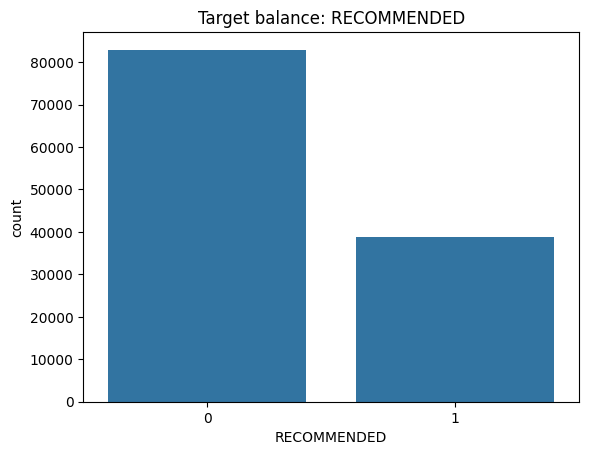

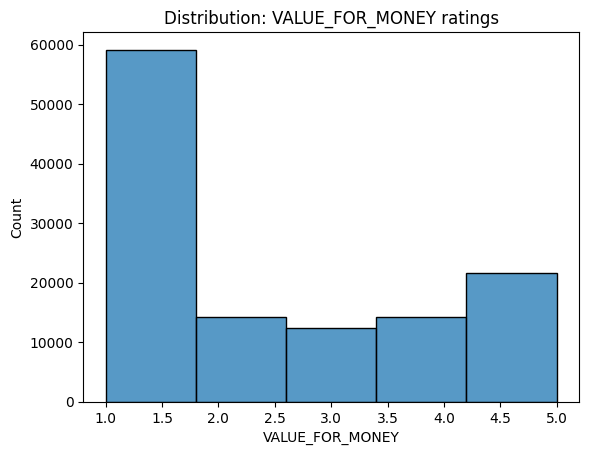

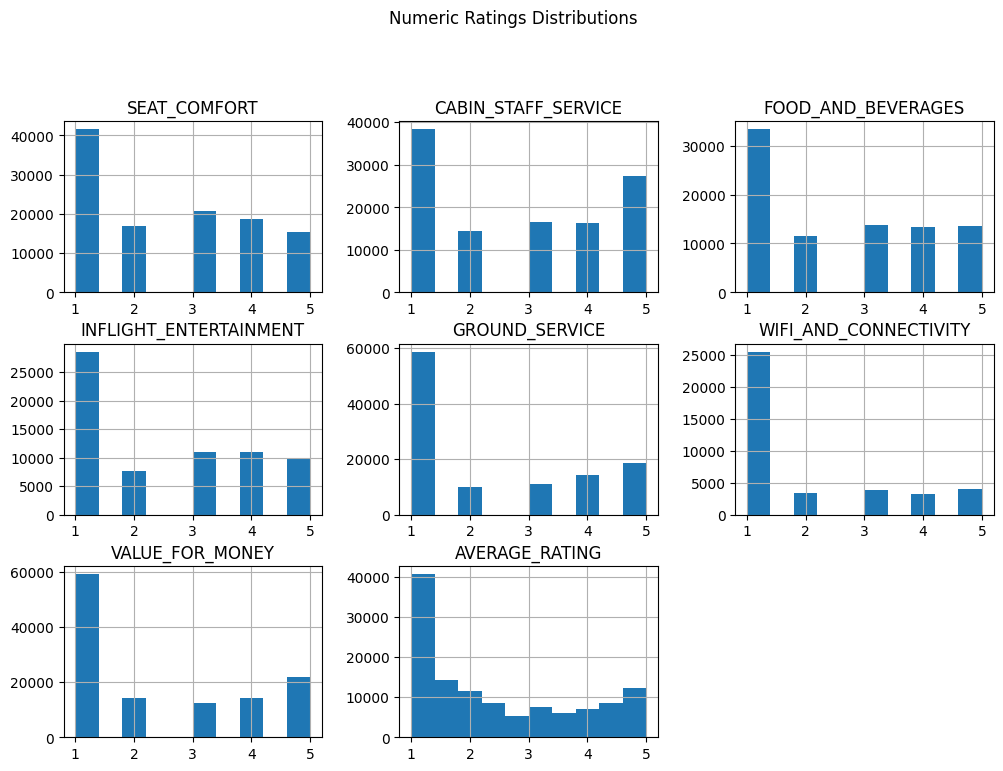

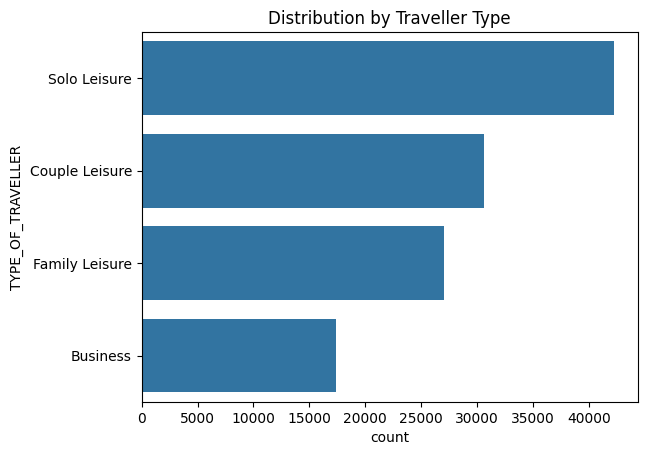

In [610]:
# Plot categorical distributions (testable)
def plot_categorical_distributions(pdf_sample):
    sns.countplot(x=pdf_sample["RECOMMENDED"])
    plt.title("Target balance: RECOMMENDED")
    plt.show()
    sns.histplot(pdf_sample["VALUE_FOR_MONEY"], bins=5, kde=False)
    plt.title("Distribution: VALUE_FOR_MONEY ratings")
    plt.show()
    pdf_sample[NUMERIC_COLS].hist(figsize=(12, 8), bins=10)
    plt.suptitle("Numeric Ratings Distributions", y=1.02)
    plt.show()
    sns.countplot(y=pdf_sample["TYPE_OF_TRAVELLER"], order=pdf_sample["TYPE_OF_TRAVELLER"].value_counts().index)
    plt.title("Distribution by Traveller Type")
    plt.show()

plot_categorical_distributions(pdf_sample)

The plots above illustrate the balance of targets, the spread of numeric ratings, and the sufficiency of categorical segments:

1. **RECOMMENDED (binary target)**  
   - The left chart shows ~68% *Not Recommend* vs. ~32% *Recommend*.  
   - The imbalance is moderate and should be addressed in evaluation (ROC-AUC, F1-score, balanced accuracy).

2. **VALUE_FOR_MONEY (ordinal target)**  
   - Ratings are heavily skewed: nearly half of customers rated value as **1**, while fewer than 20% gave it a **5**.  
   - This aligns with earlier descriptive stats and highlights customer dissatisfaction with value.

3. **Numeric rating features**  
   - Histograms show most sub-ratings are concentrated at the lower end (1–2).  
   - `CABIN_STAFF_SERVICE` is rated somewhat higher compared to others, while `GROUND_SERVICE` and `WIFI_AND_CONNECTIVITY` are consistently low.  
   - No values fall outside the 1–5 scale, confirming validity.

4. **Categorical segment sufficiency (example: Traveller Type)**  
   - Distribution is fairly balanced: Solo (35%), Couple (25%), Family (22%), Business (14%).  
   - This ensures sufficient coverage across traveler types for comparative analysis.

**Key takeaway:** Both targets and most features are strongly skewed toward negative reviews, reflecting customer dissatisfaction. Categorical coverage is adequate (except imbalanced seat classes and long-tailed airlines). These insights will guide feature engineering and model evaluation strategies.


### Summary
**1. Data Shape**
- **121,821 rows** and **25 columns**
- Rich set of numeric ratings, categorical labels, and review text.

**2. Missing Values**
- Major gaps:
  - **Wi-Fi & Connectivity** → 67% missing
  - **Inflight Entertainment** → 44%
  - **Food & Beverages** → 30%
- Moderate gaps (7–8%): Seat comfort, cabin staff service, ground service.
- Target (`RECOMMENDED`) and key fields (Airline, Rating Band) are **fully populated**.

**3. Target Balance**
- **RECOMMENDED (binary classification)**
  - 68% = Not Recommend
  - 32% = Recommend
  - Imbalanced (roughly 2:1), may need stratified sampling or class weights.
- **VALUE_FOR_MONEY (regression, 1–5)**
  - Skewed toward **1-star (49%)**
  - 18% gave 5-star, others spread thinly across 2–4.

**4. Numeric Ratings**
- Most service ratings (1–5 scale) are **skewed low** (many 1s).
- Example: Wi-Fi mean = 1.9, Cabin Staff mean = 2.8.
- Average rating across flights = ~2.4, with long tail to 5.

**5. Segment Distributions**
- **Seat Type**
  - Economy: 101K (dominant)
  - Business: 13K
  - Premium Economy: 4.5K
  - First Class: 2K
- **Traveller Type**
  - Solo Leisure: 42K
  - Couple Leisure: 30K
  - Family Leisure: 27K
  - Business: 17K
- **Rating Band**
  - Bad: 58.7K
  - Medium: 36.7K
  - Good: 26.4K
- **Airlines**
  - Large representation from multiple carriers (e.g., American 5.9K, Spirit 4.7K, United 4.5K, Frontier 3.5K).
  
**6. Key Takeaways**
- **Plenty of data** for modeling (120K+ rows).
- Need to handle **missing service ratings** (especially Wi-Fi & entertainment).
- Targets:
  - Classification: `RECOMMENDED` (imbalanced but workable).
  - Regression: `VALUE_FOR_MONEY` (heavily skewed toward 1).
- Data is dominated by **Economy class & leisure travelers**, which may bias models.



## 2. Business-Relevant Questions

**2.1 Which features have the strongest correlation with VALUE_FOR_MONEY and RECOMMENDED?**

We explored how service-related ratings (seat comfort, staff service, food, etc.) correlate with the two key target variables:  
- **VALUE_FOR_MONEY** (1–5 ordinal rating)  
- **RECOMMENDED** (binary: 0 = Not Recommend, 1 = Recommend)  

A correlation heatmap was computed across all numeric features and targets:  

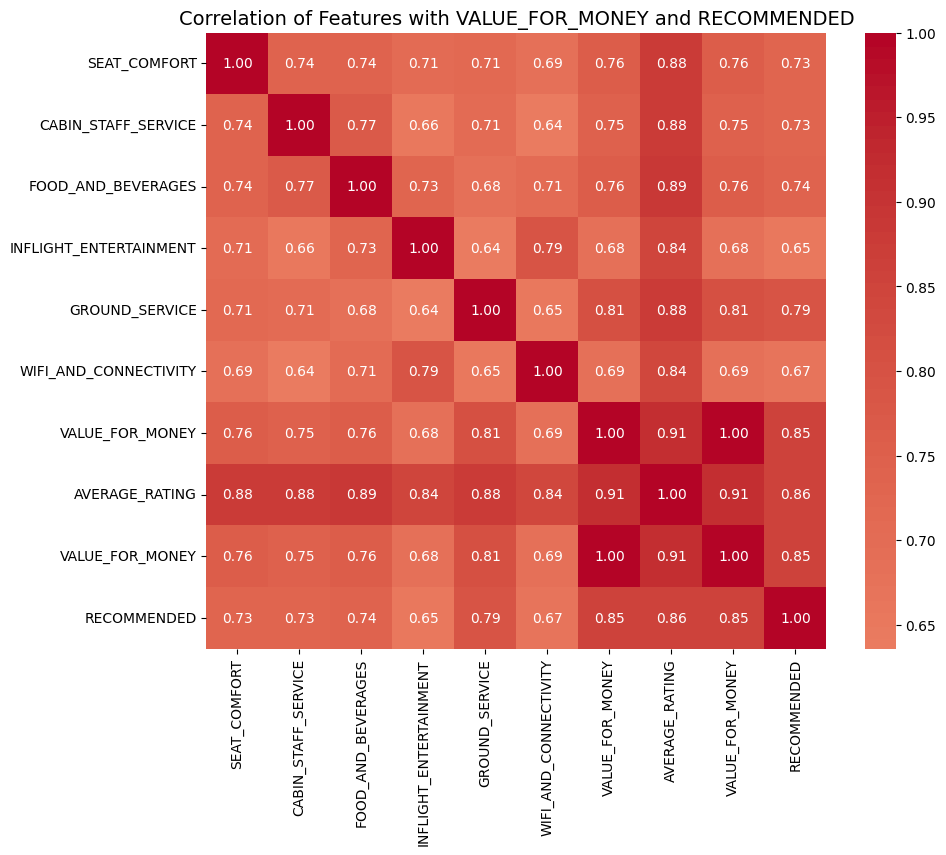

In [611]:
# Correlation heatmap (testable)
corr_pdf = pdf_sample.copy()
corr_pdf["RECOMMENDED"] = (
    corr_pdf["RECOMMENDED"].astype(str).str.lower().isin(["true","1","yes"])
).astype(int)
corr_matrix = corr_pdf[NUMERIC_COLS + ["VALUE_FOR_MONEY", "RECOMMENDED"]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation of Features with VALUE_FOR_MONEY and RECOMMENDED", fontsize=14)
plt.show()


**Key Findings:**  
- **Average Rating** shows the **strongest correlation** with both targets (0.88 with VALUE_FOR_MONEY, 0.86 with RECOMMENDED).  
- **Ground Service, Food & Beverages, and Cabin Staff Service** also have strong positive relationships (0.75–0.81 range).  
- **Wi-Fi & Connectivity** is positively correlated but weaker (0.65–0.69).  
- Overall, all service features are **positively associated** with customer perception of value and recommendation, but **not equally influential**.  

**Business Insight:** Improving **core in-flight and ground services** (seat comfort, staff, food, ground service) appears more impactful on recommendation likelihood than focusing only on Wi-Fi or entertainment. This aligns with the idea that **basic service quality drives loyalty**, while extras provide incremental value.  

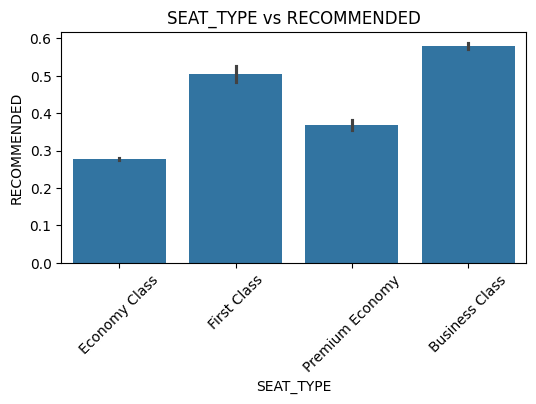

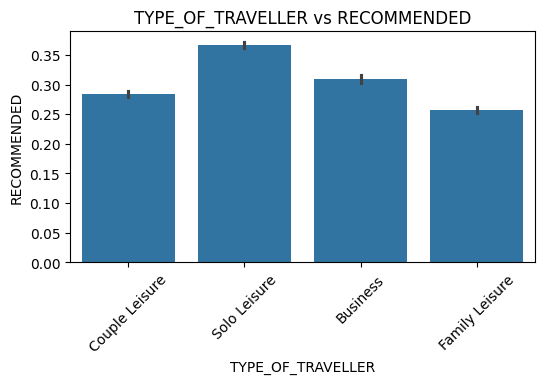

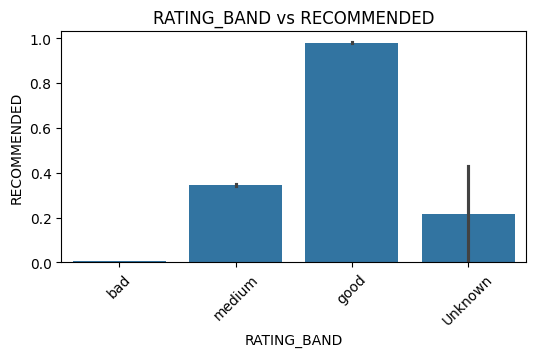

In [612]:
# Bar plots for categorical features vs RECOMMENDED
for col in CATEGORICAL_COLS:
    if col == "AIRLINE":
        continue
    plt.figure(figsize=(6,3))
    sns.barplot(x=pdf_sample[col], y=pdf_sample[TARGET_COL])
    plt.title(f"{col} vs RECOMMENDED")
    plt.xticks(rotation=45)
    plt.show()

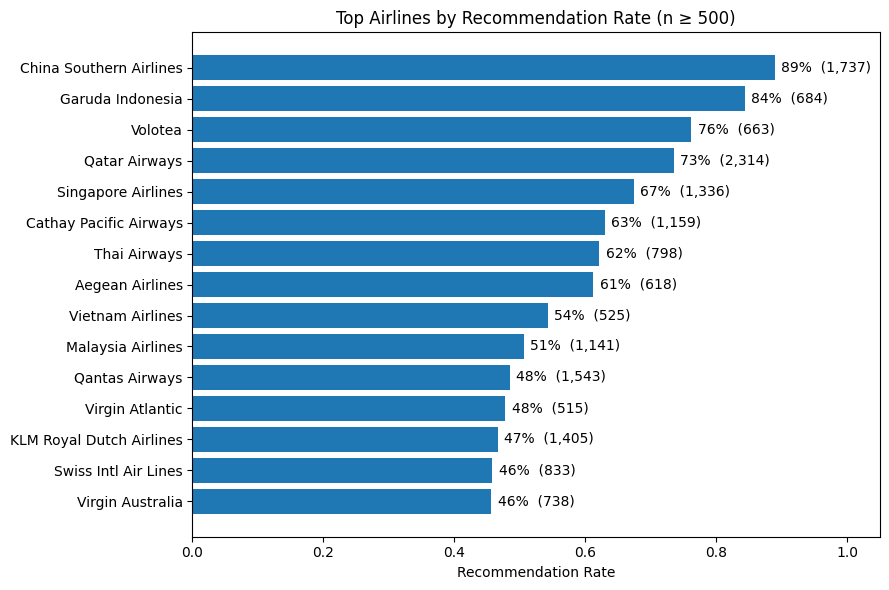

In [613]:
# Airline aggregation (testable)
TOP_N = 15
MIN_COUNT = 500
CLEAN_BAD_VALUES = {"Read more", "", None}
air = pdf_sample.copy()
air["AIRLINE"] = air["AIRLINE"].replace(list(CLEAN_BAD_VALUES), np.nan)
air = air.dropna(subset=["AIRLINE"])
agg = (air
       .groupby("AIRLINE", as_index=False)["RECOMMENDED"]
       .agg(recommend_rate="mean", n="size"))
agg = agg.query("n >= @MIN_COUNT")
best = (agg.query("n >= @MIN_COUNT")
          .sort_values(["recommend_rate", "n"], ascending=[False, False])
          .head(TOP_N)
          .sort_values("recommend_rate", ascending=True))
plt.figure(figsize=(9, 6))
bars = plt.barh(best["AIRLINE"], best["recommend_rate"])
for bar, rate, n in zip(bars, best["recommend_rate"], best["n"]):
    x = bar.get_width()
    plt.text(x + 0.01, bar.get_y() + bar.get_height()/2,
             f"{rate:.0%}  ({n:,})", va="center", fontsize=10)
plt.xlabel("Recommendation Rate")
plt.title("Top Airlines by Recommendation Rate (n ≥ 500)")
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()


#### Correlation Insights  
- **Average Rating** is the strongest driver of both VALUE_FOR_MONEY (0.88) and RECOMMENDED (0.86).  
- **Ground Service, Food & Beverages, and Cabin Staff Service** also show strong positive correlations (0.75–0.81).  
- **Wi-Fi & Connectivity** is weaker (0.65–0.69), suggesting amenities matter less than core service quality.  

#### Airline-Level Insights  
Two complementary views highlight the gap between volume and satisfaction:  
- **By Volume:** Major carriers (American, United, Delta, Spirit, Frontier) dominate reviews but have **low recommendation rates (12–29%)**.  
- **By Recommendation Rate (≥500 reviews):** Premium carriers stand out — **China Southern (89%)**, **Garuda Indonesia (84%)**, **Qatar (73%)**, and **Singapore (67%)** achieve much higher satisfaction.  

#### Takeaway  
Customer loyalty is driven more by **service quality** than amenities. Large carriers face widespread dissatisfaction, while premium airlines show that **consistent quality drives strong recommendation rates**.  

**2.2 Do economy passengers rate lower on VALUE_FOR_MONEY than premium cabins?**

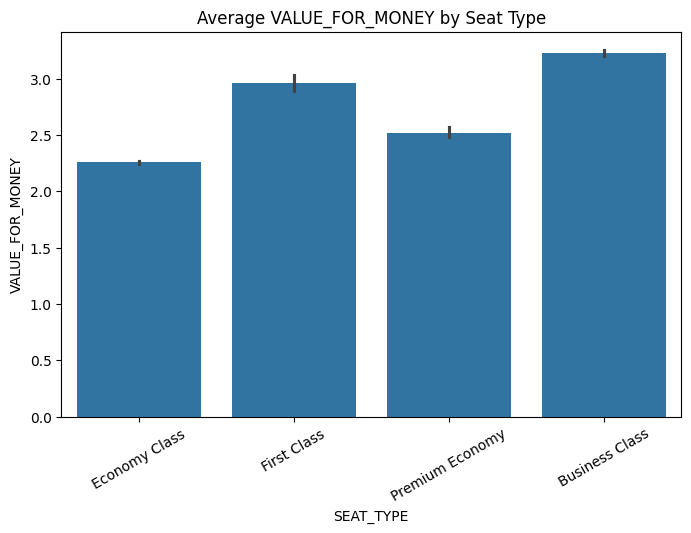

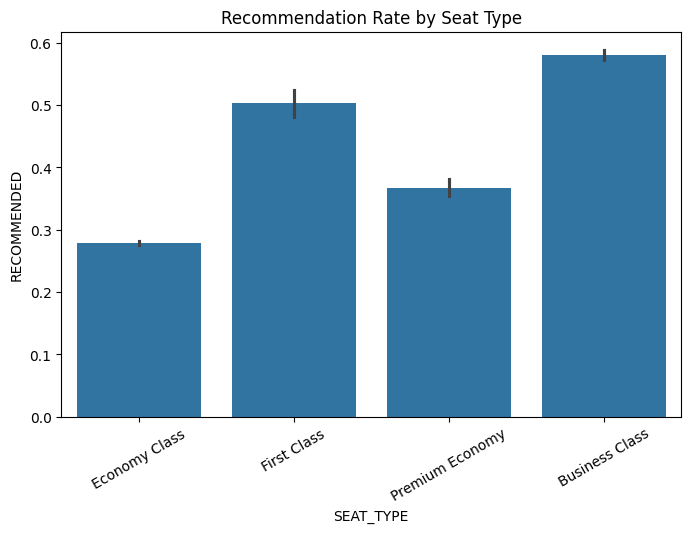

In [614]:
# Average VALUE_FOR_MONEY by seat type
plt.figure(figsize=(8,5))
sns.barplot(x="SEAT_TYPE", y="VALUE_FOR_MONEY", data=pdf_sample)
plt.title("Average VALUE_FOR_MONEY by Seat Type")
plt.xticks(rotation=30)
plt.show()

# Recommend rate by seat type
plt.figure(figsize=(8,5))
sns.barplot(x="SEAT_TYPE", y="RECOMMENDED", data=corr_pdf, estimator=lambda x: sum(x)/len(x))
plt.title("Recommendation Rate by Seat Type")
plt.xticks(rotation=30)
plt.show()



**2.3 Do traveller segments (business/leisure/family/solo) differ in satisfaction?**

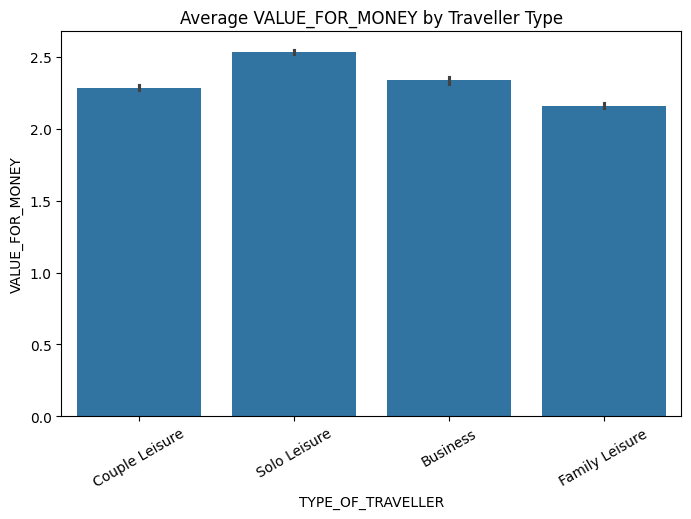

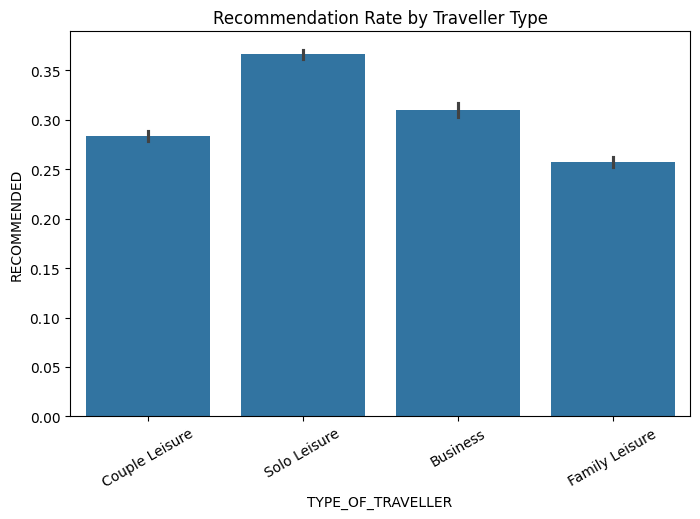

In [615]:
# VALUE_FOR_MONEY by traveller type
plt.figure(figsize=(8,5))
sns.barplot(x="TYPE_OF_TRAVELLER", y="VALUE_FOR_MONEY", data=pdf_sample)
plt.title("Average VALUE_FOR_MONEY by Traveller Type")
plt.xticks(rotation=30)
plt.show()

# Recommend rate by traveller type
plt.figure(figsize=(8,5))
sns.barplot(x="TYPE_OF_TRAVELLER", y="RECOMMENDED", data=corr_pdf, estimator=lambda x: sum(x)/len(x))
plt.title("Recommendation Rate by Traveller Type")
plt.xticks(rotation=30)
plt.show()


**Findings:**
- **VALUE_FOR_MONEY**: Economy passengers rate significantly lower (~2.3) compared to Premium Economy (~2.5), Business (~3.2), and First Class (~3.0).  
- **Recommendation Rate**: Economy has the lowest recommendation rate (~28%), while Business (~58%) and First (~51%) perform much higher. Premium Economy sits in the middle (~37%).  

**Key Takeaway:**  
Economy passengers consistently feel they receive the least value and are least likely to recommend. Premium cabins, particularly Business Class, deliver higher perceived value and stronger loyalty, justifying their pricing premium.

### 2.4 Top Airlines by Negative Reviews (may add this)

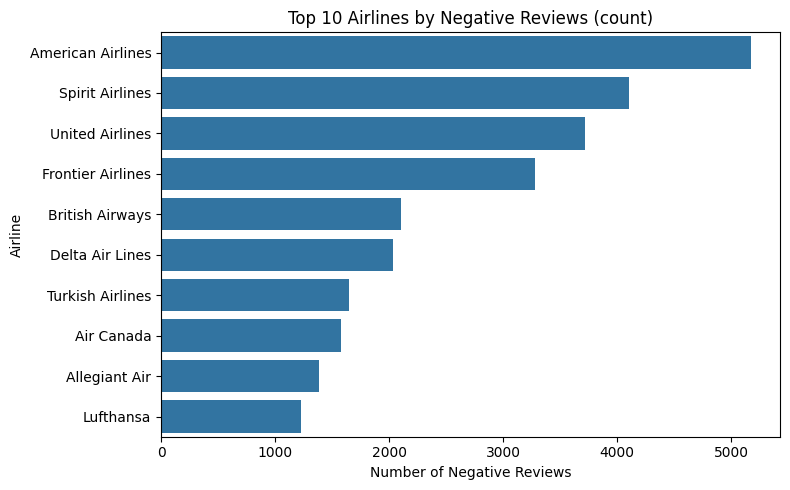

In [616]:
# Filter for not recommended
neg_pdf = corr_pdf[corr_pdf["RECOMMENDED"] == 0].copy()

# Clean obvious junk airline labels
neg_pdf["AIRLINE"] = neg_pdf["AIRLINE"].replace(
    {"Read more": None, "Frontier Airlines3810 Reviews": None, "": None}
)
neg_pdf = neg_pdf.dropna(subset=["AIRLINE"])

# Top airlines by negative reviews (count)
top_airlines = (
    neg_pdf.groupby("AIRLINE")
           .size()
           .sort_values(ascending=False)
           .head(10)
)

# Plot (horizontal for readability)
plt.figure(figsize=(8,5))
sns.barplot(y=top_airlines.index.astype(str), x=top_airlines.values, orient="h")
plt.title("Top 10 Airlines by Negative Reviews (count)")
plt.xlabel("Number of Negative Reviews")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()



The analysis of non-recommended reviews shows that **American Airlines, Spirit Airlines, and United Airlines** have the highest number of negative reviews, far ahead of others. This suggests that these airlines may need to prioritize addressing customer dissatisfaction compared to competitors.

In [617]:
# Join fact to DIM_LOCATION (origin & destination) and bring to pandas
from snowflake.snowpark.functions import col

DIM_LOCATION = "DIM_LOCATION"   # adjust if fully qualified (e.g., MARTS.DIM_LOCATION)

fact_cols = [
    "ORIGIN_LOCATION_ID", "DESTINATION_LOCATION_ID",
    "WIFI_AND_CONNECTIVITY", "INFLIGHT_ENTERTAINMENT",
    "RECOMMENDED", "VALUE_FOR_MONEY", "AIRCRAFT_ID"
]

loc = (session.table(DIM_LOCATION)
       .select(col("LOCATION_ID").alias("LOC_ID"),
               col("CITY"), col("AIRPORT")))

fact = session.table(FACT_TABLE).select(*fact_cols)

# Origin join
j1 = (fact.join(loc, fact["ORIGIN_LOCATION_ID"] == loc["LOC_ID"], how="left")
          .select(fact["*"], col("CITY").alias("ORIGIN_CITY"), col("AIRPORT").alias("ORIGIN_AIRPORT")))

# Destination join
j2 = (j1.join(loc, j1["DESTINATION_LOCATION_ID"] == loc["LOC_ID"], how="left")
         .select(j1["*"], col("CITY").alias("DEST_CITY"), col("AIRPORT").alias("DEST_AIRPORT")))

eda23 = j2.to_pandas()

# Normalize RECOMMENDED to {0,1}
eda23["RECOMMENDED"] = (
    eda23["RECOMMENDED"].astype(str).str.lower().isin(["true","1","yes"])
).astype(int)

eda23.head()


,ORIGIN_LOCATION_ID,DESTINATION_LOCATION_ID,WIFI_AND_CONNECTIVITY,INFLIGHT_ENTERTAINMENT,RECOMMENDED,VALUE_FOR_MONEY,AIRCRAFT_ID,ORIGIN_CITY,ORIGIN_AIRPORT,DEST_CITY,DEST_AIRPORT
0,2857,2070,5.0,3.0,0,3.0,32,Miami,MIA,Jakarta,CGK
1,3104,628,1.0,3.0,0,1.0,42,New York,JFK,Budapest,BUD
2,342,4132,NaN,NaN,0,1.0,42,Bangkok,BKK,Siem Reap,Unknown
3,4740,4740,NaN,5.0,1,5.0,42,Unknown,Unknown,Unknown,Unknown
4,2617,1469,NaN,NaN,0,2.0,3,London,LHR,Frankfurt,FRA


### 2.5 Origin/Destination Airport Experience (may add this)

We evaluated origin airports with at least 150 reviews to reduce noise.  


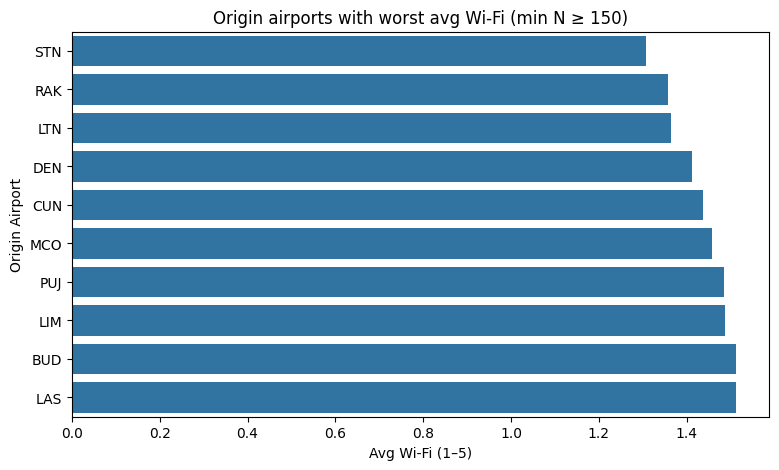

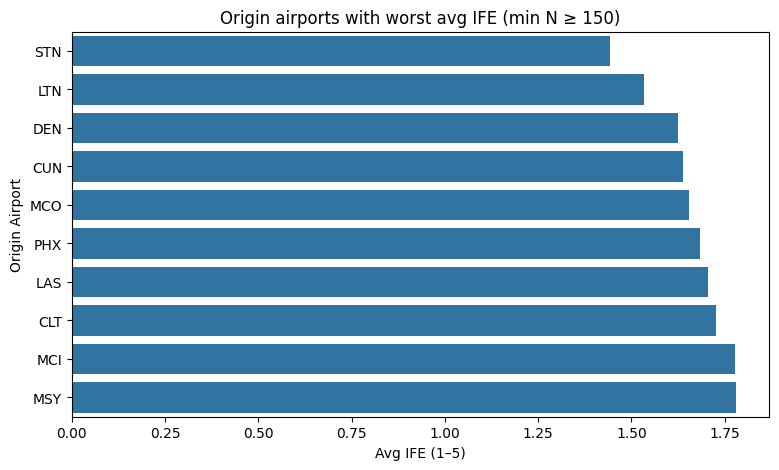

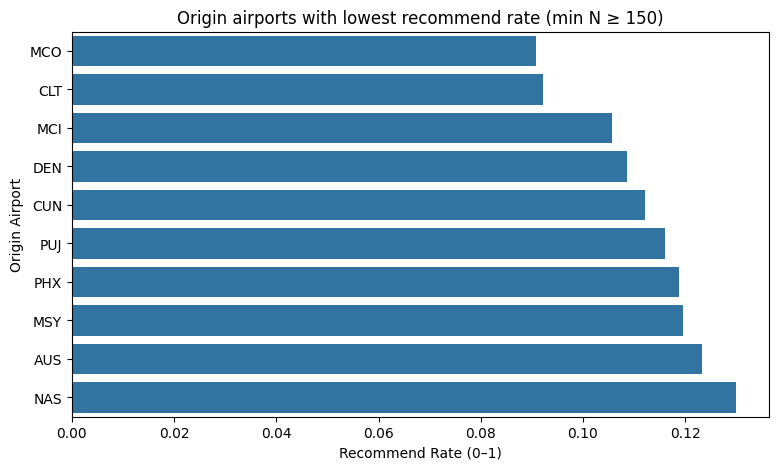

In [618]:
# Small airports can be noisy; set a minimum review count
MIN_N = 150

origin_metrics = (eda23.groupby("ORIGIN_AIRPORT")
                  .agg(n=("RECOMMENDED","size"),
                       wifi=("WIFI_AND_CONNECTIVITY","mean"),
                       ife=("INFLIGHT_ENTERTAINMENT","mean"),
                       rec_rate=("RECOMMENDED","mean"))
                  .dropna(subset=["wifi","ife"])
                  .query("n >= @MIN_N")
                  .sort_values("n", ascending=False))

# Worst Wi-Fi (top 10)
worst_wifi_o = origin_metrics.sort_values("wifi", ascending=True).head(10)

plt.figure(figsize=(9,5))
sns.barplot(y=worst_wifi_o.index, x=worst_wifi_o["wifi"])
plt.title("Origin airports with worst avg Wi-Fi (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg Wi-Fi (1–5)")
plt.ylabel("Origin Airport")
plt.show()

# Worst IFE (top 10)
worst_ife_o = origin_metrics.sort_values("ife", ascending=True).head(10)

plt.figure(figsize=(9,5))
sns.barplot(y=worst_ife_o.index, x=worst_ife_o["ife"])
plt.title("Origin airports with worst avg IFE (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg IFE (1–5)")
plt.ylabel("Origin Airport")
plt.show()

# Lowest recommendation rate (top 10)
lowest_rec_o = origin_metrics.sort_values("rec_rate", ascending=True).head(10)

plt.figure(figsize=(9,5))
sns.barplot(y=lowest_rec_o.index, x=lowest_rec_o["rec_rate"])
plt.title("Origin airports with lowest recommend rate (min N ≥ %d)" % MIN_N)
plt.xlabel("Recommend Rate (0–1)")
plt.ylabel("Origin Airport")
plt.show()


- **Wi-Fi**: Stansted (STN), Marrakech (RAK), and London Luton (LTN) ranked lowest, with average ratings barely above 1 on a 5-point scale.  
- **In-Flight Entertainment (IFE)**: STN and LTN again appear among the worst, along with Denver (DEN) and Cancun (CUN).  
- **Recommendation Rate**: Major hubs like Orlando (MCO), Charlotte (CLT), and Denver (DEN) are among the lowest-rated, with recommendation rates around 10–12%.  

**Takeaway**: Certain airports consistently underperform across multiple service dimensions (e.g., STN, DEN, CUN), suggesting broader issues with the travel experience originating from these hubs.

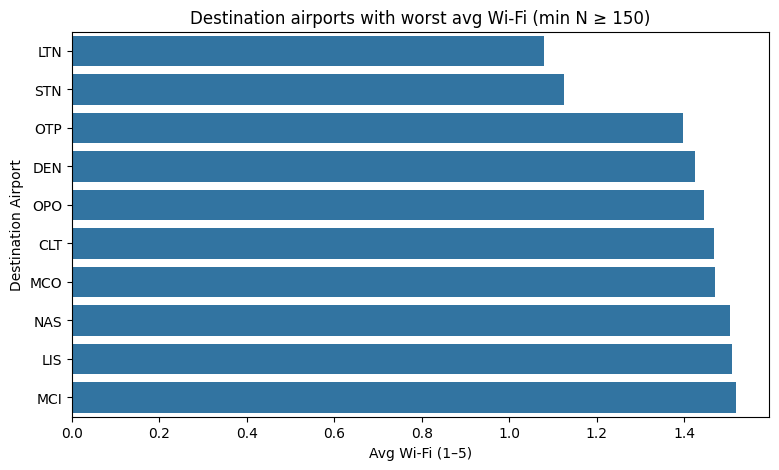

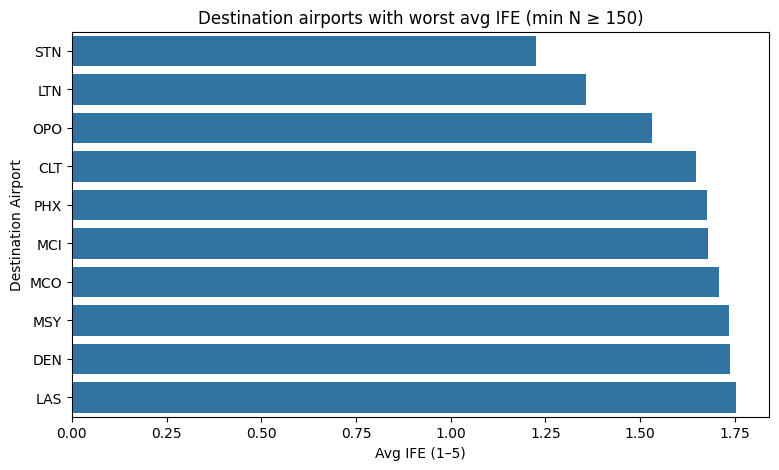

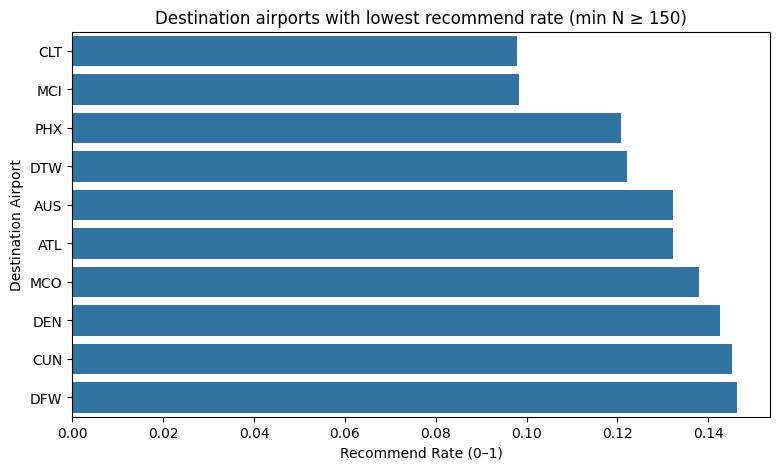

In [619]:
dest_metrics = (eda23.groupby("DEST_AIRPORT")
                .agg(n=("RECOMMENDED","size"),
                     wifi=("WIFI_AND_CONNECTIVITY","mean"),
                     ife=("INFLIGHT_ENTERTAINMENT","mean"),
                     rec_rate=("RECOMMENDED","mean"))
                .dropna(subset=["wifi","ife"])
                .query("n >= @MIN_N")
                .sort_values("n", ascending=False))

# Worst Wi-Fi (top 10)
worst_wifi_d = dest_metrics.sort_values("wifi", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=worst_wifi_d.index, x=worst_wifi_d["wifi"])
plt.title("Destination airports with worst avg Wi-Fi (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg Wi-Fi (1–5)")
plt.ylabel("Destination Airport")
plt.show()

# Worst IFE (top 10)
worst_ife_d = dest_metrics.sort_values("ife", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=worst_ife_d.index, x=worst_ife_d["ife"])
plt.title("Destination airports with worst avg IFE (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg IFE (1–5)")
plt.ylabel("Destination Airport")
plt.show()

# Lowest recommendation rate (top 10)
lowest_rec_d = dest_metrics.sort_values("rec_rate", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=lowest_rec_d.index, x=lowest_rec_d["rec_rate"])
plt.title("Destination airports with lowest recommend rate (min N ≥ %d)" % MIN_N)
plt.xlabel("Recommend Rate (0–1)")
plt.ylabel("Destination Airport")
plt.show()


### 2.6 Aircraft Experience (may add this)

We evaluated aircrafts with at least 150 reviews to reduce noise.  


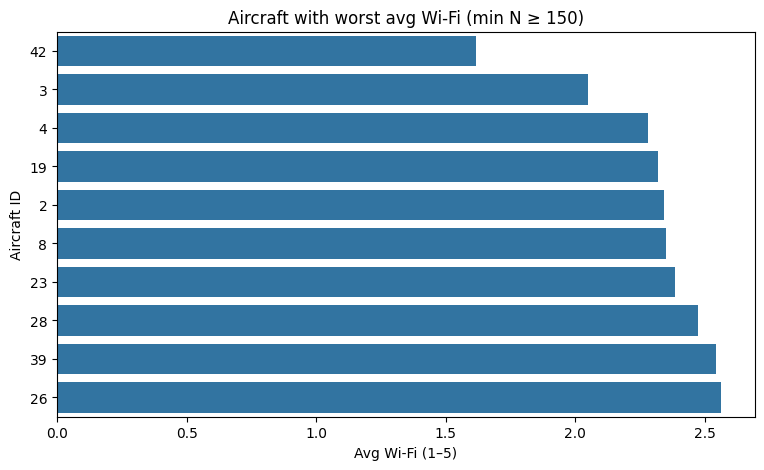

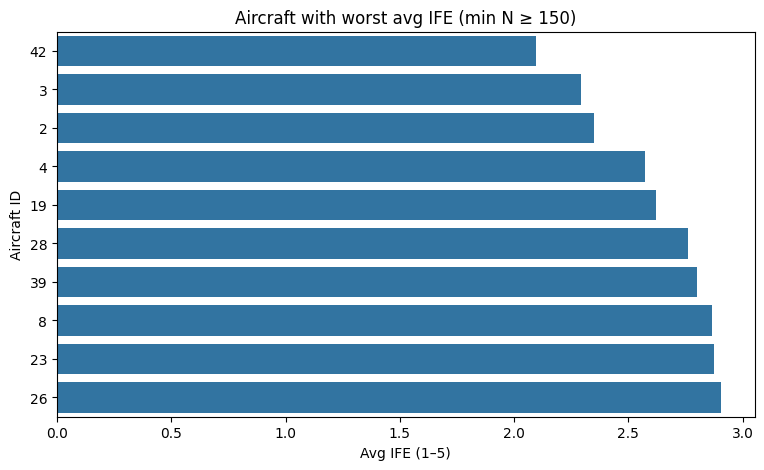

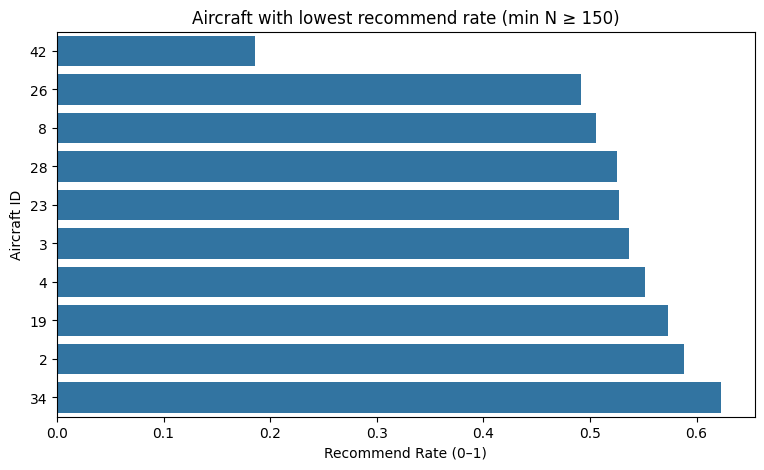

In [620]:
aircraft_metrics = (eda23.groupby("AIRCRAFT_ID")
                    .agg(n=("RECOMMENDED","size"),
                         wifi=("WIFI_AND_CONNECTIVITY","mean"),
                         ife=("INFLIGHT_ENTERTAINMENT","mean"),
                         rec_rate=("RECOMMENDED","mean"))
                    .dropna(subset=["wifi","ife"])
                    .query("n >= @MIN_N")
                    .sort_values("n", ascending=False))

# Worst Wi-Fi (top 10)
worst_wifi_ac = aircraft_metrics.sort_values("wifi", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=worst_wifi_ac.index.astype(str), x=worst_wifi_ac["wifi"])
plt.title("Aircraft with worst avg Wi-Fi (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg Wi-Fi (1–5)")
plt.ylabel("Aircraft ID")
plt.show()

# Worst IFE (top 10)
worst_ife_ac = aircraft_metrics.sort_values("ife", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=worst_ife_ac.index.astype(str), x=worst_ife_ac["ife"])
plt.title("Aircraft with worst avg IFE (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg IFE (1–5)")
plt.ylabel("Aircraft ID")
plt.show()

# Lowest recommendation rate (top 10)
lowest_rec_ac = aircraft_metrics.sort_values("rec_rate", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=lowest_rec_ac.index.astype(str), x=lowest_rec_ac["rec_rate"])
plt.title("Aircraft with lowest recommend rate (min N ≥ %d)" % MIN_N)
plt.xlabel("Recommend Rate (0–1)")
plt.ylabel("Aircraft ID")
plt.show()


**Part 2: Summary**:  
Customer satisfaction is driven primarily by **core service elements** (staff, food, comfort, ground service), with **amenities like Wi-Fi and IFE secondary**. High-volume U.S. carriers underperform on recommend rates, while **premium Asian/Middle Eastern airlines lead**. Satisfaction rises with **cabin class** and is highest among **solo travelers**, while families rate both value and recommendation lowest. Negative reviews cluster around major U.S. carriers and repeat under-performance appears at **STN, LTN, DEN, MCO, CLT** airports. For business action, airlines should **prioritize core service improvements**, **raise Economy and Family Leisure satisfaction**, **benchmark performance by rate and count**, and **target underperforming airports** with dedicated programs.


## **Part 3: Target-specific EDA:** 
3a. RECOMMENDED.

3a.1 Normalize target & quick class balance

Counts:
 RECOMMENDED
Not Recommend    82925
Recommend        38896
Name: count, dtype: int64 

Percentages (%):
 RECOMMENDED
Not Recommend    68.07
Recommend        31.93
Name: count, dtype: float64


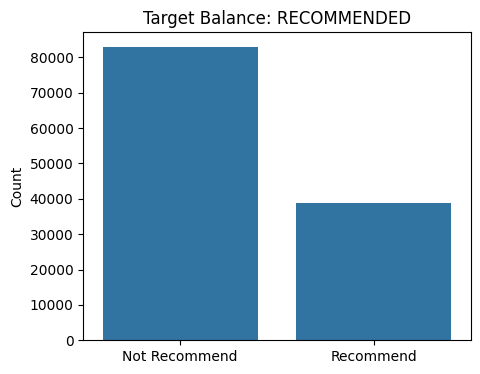

In [621]:
df3 = pdf_sample.copy()
df3["RECOMMENDED"] = (
    df3["RECOMMENDED"].astype(str).str.lower().isin(["true","1","yes"])
).astype(int)

# Class balance table
bal = df3["RECOMMENDED"].value_counts().rename(index={0:"Not Recommend",1:"Recommend"})
print("Counts:\n", bal, "\n")
print("Percentages (%):\n", (bal / bal.sum() * 100).round(2))

# Bar chart
plt.figure(figsize=(5,4))
sns.countplot(x=df3["RECOMMENDED"].map({0:"Not Recommend",1:"Recommend"}))
plt.title("Target Balance: RECOMMENDED")
plt.xlabel("")
plt.ylabel("Count")
plt.show()


The target variable is moderately imbalanced, with about **68% of passengers not recommending** their airline experience and only **32% recommending** it. This indicates that overall sentiment leans negative, and any model trained on this data must account for the imbalance. A naive classifier that always predicts “Not Recommend” would already achieve ~68% accuracy, so future modeling should emphasize balanced metrics (e.g., AUC, F1, precision-recall) and may benefit from resampling or class weighting strategies.


3a.2 Service ratings vs RECOMMENDED (mean difference)

In [622]:
# Compute mean rating by class for each numeric feature
means = (df3
         .groupby("RECOMMENDED")[NUMERIC_COLS]
         .mean()
         .T
         .rename(index=str))
means.columns = ["Not Recommend","Recommend"]
means_sorted = means.sort_values("Recommend", ascending=False)
means_sorted.round(3)


,Not Recommend,Recommend
CABIN_STAFF_SERVICE,1.980,4.451
VALUE_FOR_MONEY,1.457,4.362
GROUND_SERVICE,1.467,4.162
AVERAGE_RATING,1.613,4.125
SEAT_COMFORT,1.795,4.035
FOOD_AND_BEVERAGES,1.663,3.942
INFLIGHT_ENTERTAINMENT,1.752,3.794
WIFI_AND_CONNECTIVITY,1.397,3.566


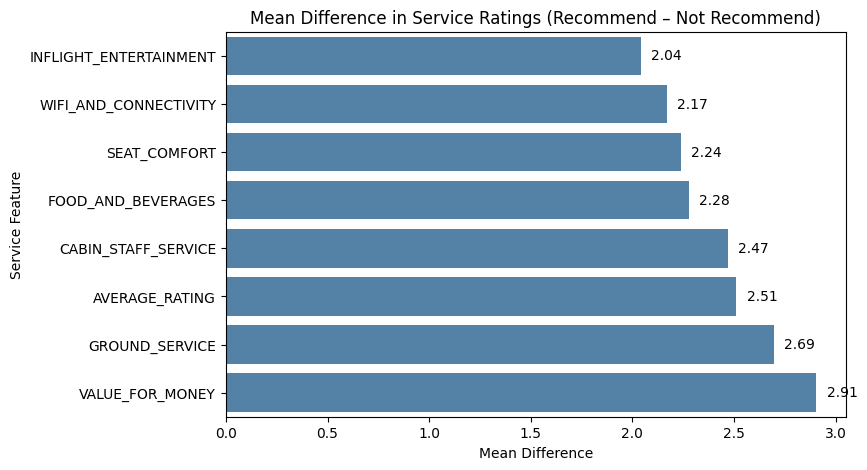

In [623]:
# Suggested to add to 3a.2

# Reason:
# Plotting the mean differences helps quickly visualize which service features
# most strongly separate recommenders from non-recommenders. 
# Unlike the table, this chart makes the relative ranking and magnitude 
# of differences immediately clear for interpretation and later comparison with model feature importance.

# Compute mean differences
mean_diff = (means["Recommend"] - means["Not Recommend"]).sort_values(ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=mean_diff.values, y=mean_diff.index, color="steelblue")
plt.title("Mean Difference in Service Ratings (Recommend – Not Recommend)")
plt.xlabel("Mean Difference")
plt.ylabel("Service Feature")

# Add value labels
for i, v in enumerate(mean_diff.values):
    plt.text(v + 0.05, i, f"{v:.2f}", va='center')

plt.show()


The mean difference plot shows that passengers who recommend their airline experience give consistently higher ratings across all service dimensions. The strongest gaps appear in **Value for Money (+2.91)**, **Ground Service (+2.69)**, and **Average Rating (+2.51)**, followed closely by **Cabin Staff Service (+2.47)**. Core experience factors (value, ground, staff, seat comfort, and food) dominate, while **Wi-Fi (+2.17)** and **In-flight Entertainment (+2.04)** show smaller but still meaningful differences. This reinforces that recommendation is driven most by the fundamentals of service and perceived value, with amenities playing a secondary role. The consistent positive separation across every feature also suggests these variables are highly predictive for modeling.

3a.3 Distributions of key ratings by class (box/violin)

In [624]:
key_cols = ["SEAT_COMFORT","CABIN_STAFF_SERVICE","FOOD_AND_BEVERAGES",
            "INFLIGHT_ENTERTAINMENT","WIFI_AND_CONNECTIVITY","AVERAGE_RATING"]

melted = df3[["RECOMMENDED"] + key_cols].melt(id_vars="RECOMMENDED",
                                              var_name="feature", value_name="score")
melted["class"] = melted["RECOMMENDED"].map({0:"Not Recommend",1:"Recommend"})

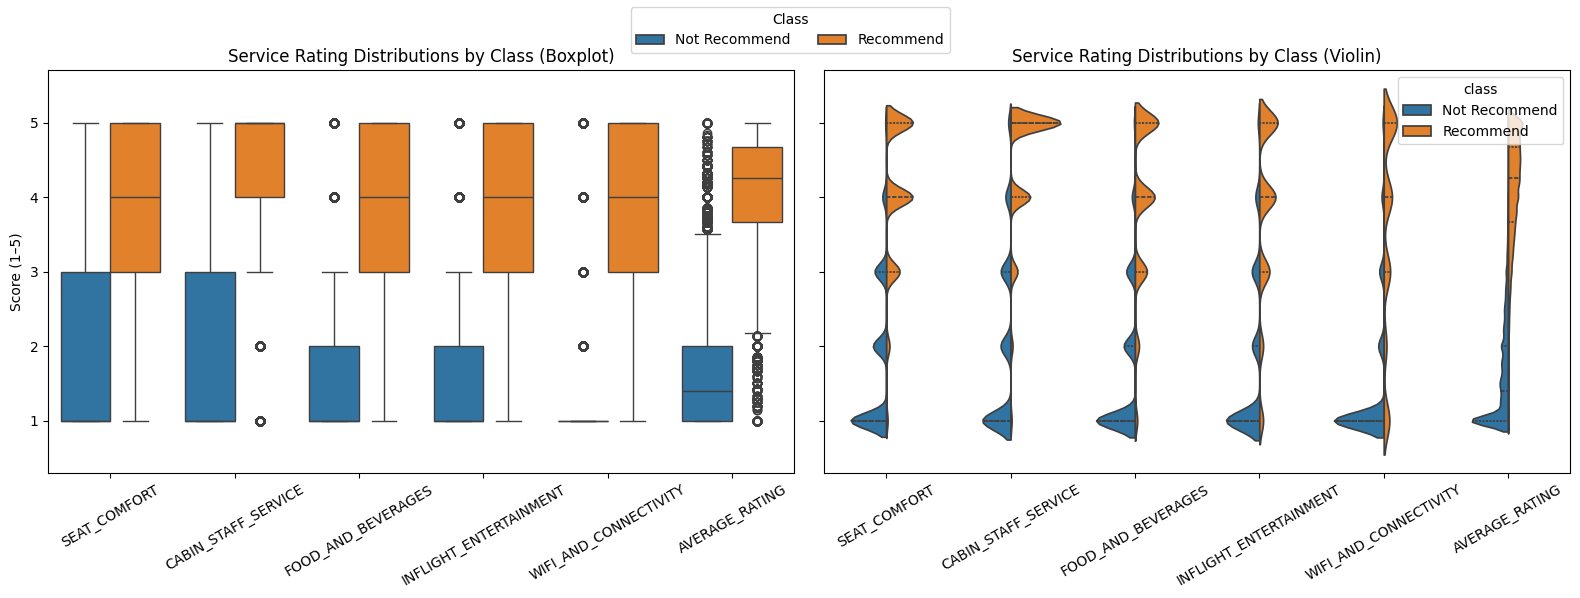

In [625]:
# Reason:
# Boxplots are good for showing summary statistics (median, quartiles, spread).
# Violin plots add the full distribution shape, revealing how scores cluster 
# (e.g., non-recommenders spiking at 1, recommenders peaking at 4–5).
# Putting them side by side makes it easy to see both perspectives at once.

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# Boxplot (summary view)
sns.boxplot(data=melted, x="feature", y="score", hue="class", ax=axes[0])
axes[0].set_title("Service Rating Distributions by Class (Boxplot)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Score (1–5)")
axes[0].tick_params(axis='x', rotation=30)
axes[0].legend_.remove()  # remove duplicate legend (we'll add a shared one)

# Violin plot (distribution view)
sns.violinplot(data=melted, x="feature", y="score", hue="class",
               split=True, inner="quart", ax=axes[1])
axes[1].set_title("Service Rating Distributions by Class (Violin)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', rotation=30)

# Add one shared legend above both plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Class", loc="upper center", ncol=2)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()



The side-by-side plots provide complementary perspectives on service ratings by recommendation class. The **boxplots** (left) summarize central tendency and spread, showing that non-recommenders cluster near the lowest scores (1–2) while recommenders concentrate around 4–5 across all service dimensions. The **violin plots** (right) reveal the underlying distribution shapes, with clear spikes at 1 for non-recommenders and strong peaks at 4–5 for recommenders, emphasizing how polarized the two groups are. Together, these views show not only the average separation but also how tightly ratings are clustered, reinforcing that positive recommendations are strongly tied to consistently high service ratings, especially for staff, value, and comfort.

3a.4 Segment differences in recommend rate (seat type, traveller type)

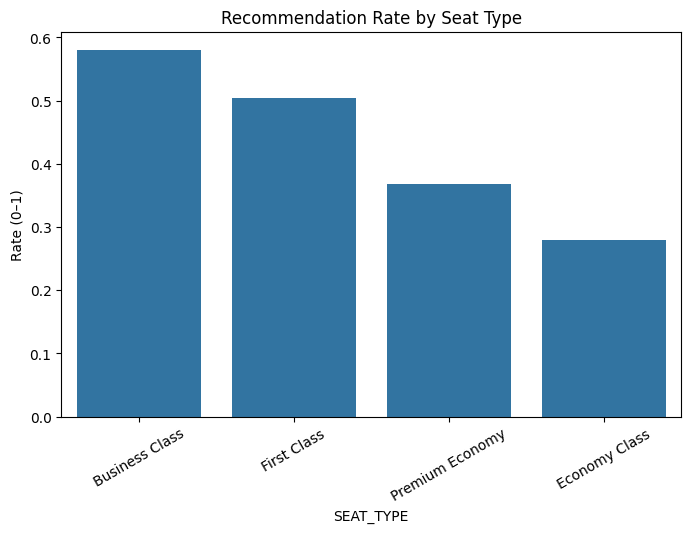

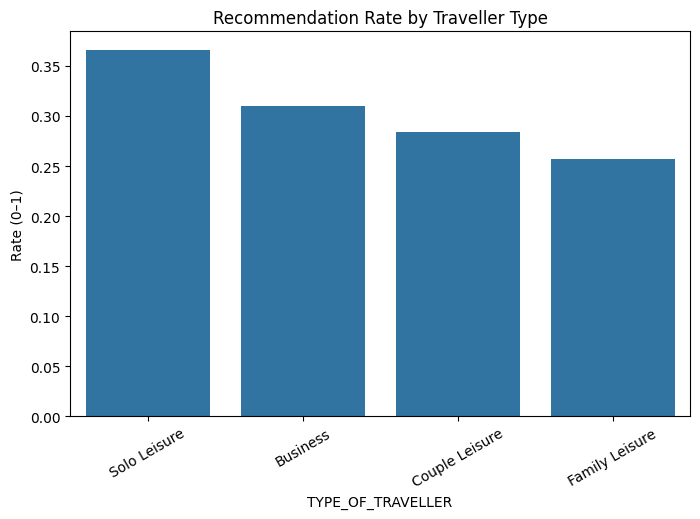

In [626]:
# Seat type
seat_rate = (df3.groupby("SEAT_TYPE")["RECOMMENDED"].mean()
             .sort_values(ascending=False))
plt.figure(figsize=(8,5))
sns.barplot(x=seat_rate.index, y=seat_rate.values)
plt.title("Recommendation Rate by Seat Type")
plt.ylabel("Rate (0–1)")
plt.xticks(rotation=30)
plt.show()

# Traveller type
trav_rate = (df3.groupby("TYPE_OF_TRAVELLER")["RECOMMENDED"].mean()
             .sort_values(ascending=False))
plt.figure(figsize=(8,5))
sns.barplot(x=trav_rate.index, y=trav_rate.values)
plt.title("Recommendation Rate by Traveller Type")
plt.ylabel("Rate (0–1)")
plt.xticks(rotation=30)
plt.show()


Segment analysis confirms that recommendation likelihood varies strongly by both cabin and traveller type. Passengers in **Business (≈58%)** and **First Class (≈51%)** are far more likely to recommend compared to **Premium Economy (≈37%)** and especially **Economy (≈28%)**, underscoring the challenge of driving loyalty in the lowest cabin. Traveller segments show a similar divide: **Solo Leisure (≈37%)** travelers are the most positive, while **Family Leisure (≈26%)** are the least likely to recommend, with Business and Couple Leisure falling in between. Together, these findings highlight that recommendation is not only driven by service quality but also by who the traveler is and what cabin they fly, making Economy and Family Leisure the priority segments for improvement.


3a.5 Airline benchmarking (multi-airline scope) — top N by volume

/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/3582163080.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_airlines.index, x=top_airlines.values, palette="Blues_r", ax=axes[0])
/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/3582163080.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=bottom_airlines.index, x=bottom_airlines.values, palette="Reds_r", ax=axes[1])


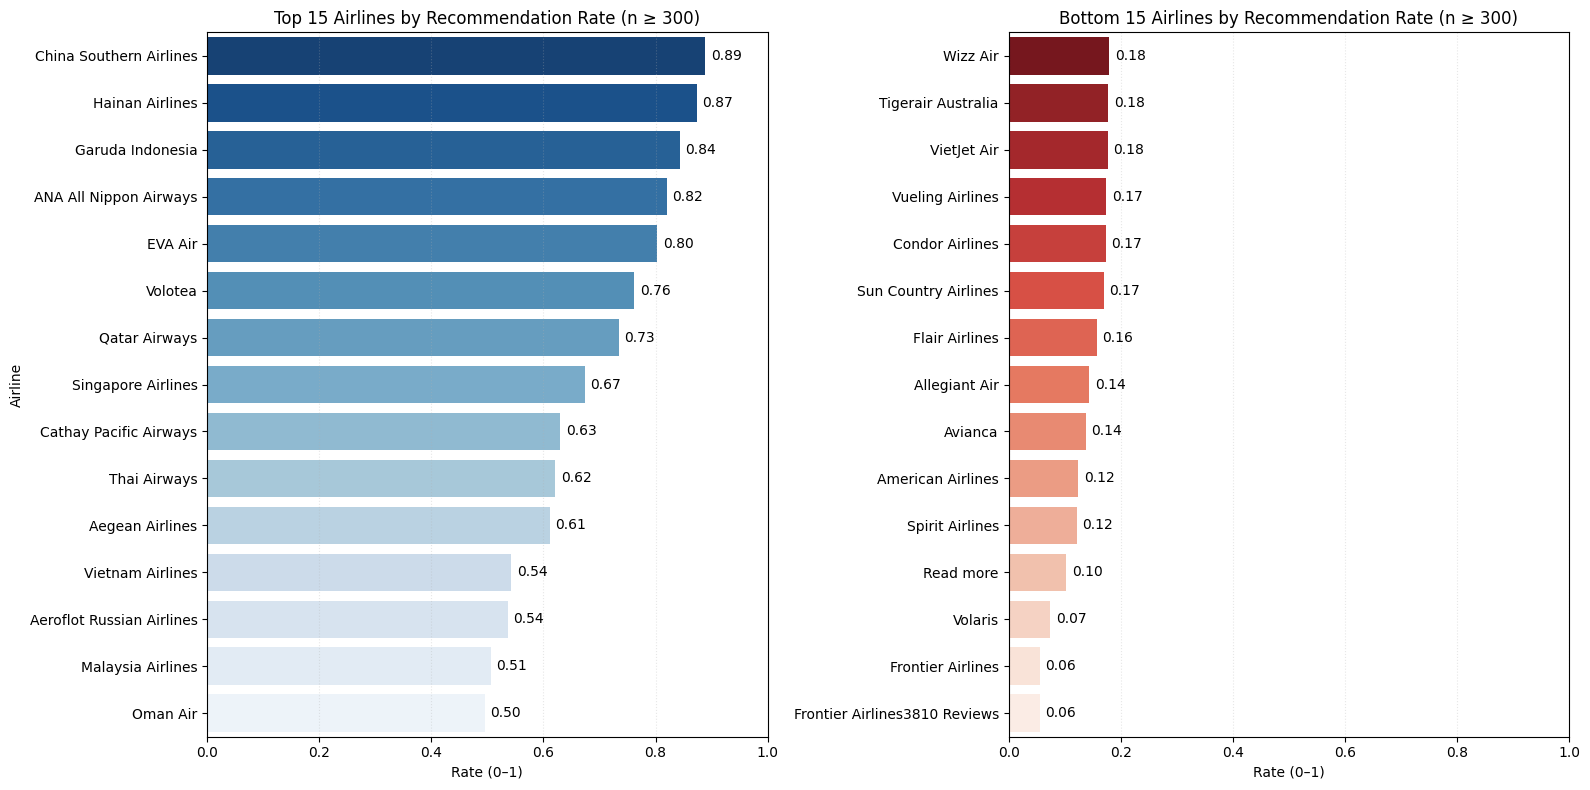

In [627]:
# Focus on airlines with enough reviews to be stable
min_n = 300
air_counts = df3["AIRLINE"].value_counts()
big_airlines = air_counts[air_counts >= min_n].index

air_rate = (df3[df3["AIRLINE"].isin(big_airlines)]
            .groupby("AIRLINE")["RECOMMENDED"].mean()
            .sort_values(ascending=False))

# --- Top & Bottom Airlines by Recommendation Rate (n ≥ min_n) ---

top_n = 15
top_airlines = air_rate.head(top_n)
bottom_airlines = air_rate.tail(top_n)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

# Top airlines (blue gradient)
sns.barplot(y=top_airlines.index, x=top_airlines.values, palette="Blues_r", ax=axes[0])
axes[0].set_title(f"Top {top_n} Airlines by Recommendation Rate (n ≥ {min_n})")
axes[0].set_xlabel("Rate (0–1)")
axes[0].set_ylabel("Airline")
for i, v in enumerate(top_airlines.values):
    axes[0].text(v + 0.01, i, f"{v:.2f}", va="center")

# Bottom airlines (red gradient)
sns.barplot(y=bottom_airlines.index, x=bottom_airlines.values, palette="Reds_r", ax=axes[1])
axes[1].set_title(f"Bottom {top_n} Airlines by Recommendation Rate (n ≥ {min_n})")
axes[1].set_xlabel("Rate (0–1)")
axes[1].set_ylabel("")
for i, v in enumerate(bottom_airlines.values):
    axes[1].text(v + 0.01, i, f"{v:.2f}", va="center")

# Shared formatting
for ax in axes:
    ax.set_xlim(0, 1)  # recommendation rate is bounded 0–1
    ax.grid(axis="x", linestyle=":", alpha=0.3)

plt.tight_layout()
plt.show()




Top airlines like China Southern, Hainan, and Garuda Indonesia achieve 80%+ recommend rates, while bottom carriers such as Wizz Air, Tigerair, and Frontier struggle below 20%. This highlights strong gaps in customer satisfaction across airlines.

3a.6 Categorical association check (chi-square)

In [628]:
# Chi-square tests show all tested categorical variables 
# (seat type, traveller type, rating band, airline) are 
# highly associated with RECOMMENDED (p ≈ 0). 
# This provides statistical confirmation of earlier visual insights 
# and flags them as important categorical predictors to consider 
# in modeling.

from scipy.stats import chi2_contingency

def chi2_summary(df, cat_col, target="RECOMMENDED"):
    ct = pd.crosstab(df[cat_col], df[target])
    chi2, p, dof, _ = chi2_contingency(ct)
    return pd.DataFrame({
        "category":[cat_col],
        "chi2":[chi2],
        "dof":[dof],
        "p_value":[p],
        "min_expected":[_.min()]
    })

cats_to_test = ["SEAT_TYPE","TYPE_OF_TRAVELLER","RATING_BAND","AIRLINE"]
out = pd.concat([chi2_summary(df3, c) for c in cats_to_test], ignore_index=True)
out.sort_values("p_value")


,category,chi2,dof,p_value,min_expected
0,SEAT_TYPE,5336.156074,3,0.000000e+00,659.041646
2,RATING_BAND,80137.489439,3,0.000000e+00,4.470034
3,AIRLINE,21907.777092,548,0.000000e+00,0.319288
1,TYPE_OF_TRAVELLER,1072.256320,3,3.801827e-232,5401.417236


/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/3986495381.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="chi2", y="category", data=out.sort_values("chi2", ascending=False), palette="Blues_r")


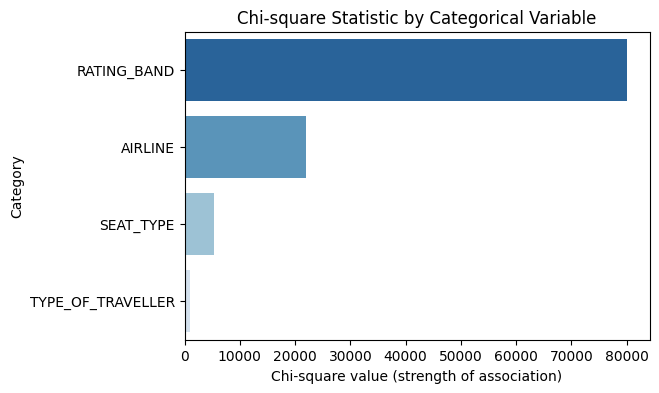

/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/3986495381.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="cramers_v", y="category", data=cramers_df, palette="Greens_r")


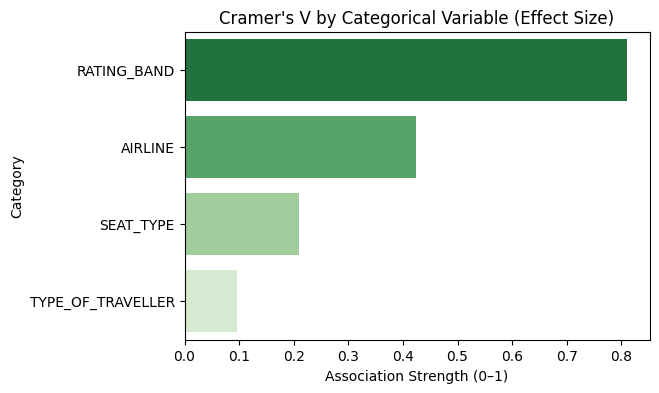

In [629]:
# Chi-square and Cramer's V (testable)
from scipy.stats import chi2_contingency
def chi2_summary(df, cat_col, target="RECOMMENDED"):
    ct = pd.crosstab(df[cat_col], df[target])
    chi2, p, dof, expected = chi2_contingency(ct)
    return pd.DataFrame({
        "category":[cat_col],
        "chi2":[chi2],
        "dof":[dof],
        "p_value":[p],
        "min_expected":[expected.min()]
    })
cats_to_test = ["SEAT_TYPE","TYPE_OF_TRAVELLER","RATING_BAND","AIRLINE"]
out = pd.concat([chi2_summary(df3, c) for c in cats_to_test], ignore_index=True)
plt.figure(figsize=(6,4))
sns.barplot(x="chi2", y="category", data=out.sort_values("chi2", ascending=False), palette="Blues_r")
plt.title("Chi-square Statistic by Categorical Variable")
plt.xlabel("Chi-square value (strength of association)")
plt.ylabel("Category")
plt.show()

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r,k)-1)))
cramers = []
for c in cats_to_test:
    ct = pd.crosstab(df3[c], df3["RECOMMENDED"])
    cramers.append({"category": c, "cramers_v": cramers_v(ct)})
cramers_df = pd.DataFrame(cramers).sort_values("cramers_v", ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x="cramers_v", y="category", data=cramers_df, palette="Greens_r")
plt.title("Cramer's V by Categorical Variable (Effect Size)")
plt.xlabel("Association Strength (0–1)")
plt.ylabel("Category")
plt.show()

All tested categorical variables show significant association with recommendation (p < 0.001). The strongest driver is **Rating Band**, followed by **Airline**, then **Seat Type** and **Traveller Type**. Effect sizes confirm that rating patterns dominate loyalty signals.

3a.7 Is AVERAGE_RATING too predictive? Leakage sanity check

In [630]:
# Correlation (point-biserial via Pearson with {0,1})
corr_avg = df3[["AVERAGE_RATING","RECOMMENDED"]].corr().iloc[0,1]
print(f"Correlation(Average Rating, RECOMMENDED) = {corr_avg:.3f}")

# If this is extremely high (e.g., >0.7), consider training a model both with and without AVERAGE_RATING
# to verify it doesn't trivially leak the decision rule behind RECOMMENDED.


Correlation(Average Rating, RECOMMENDED) = 0.857


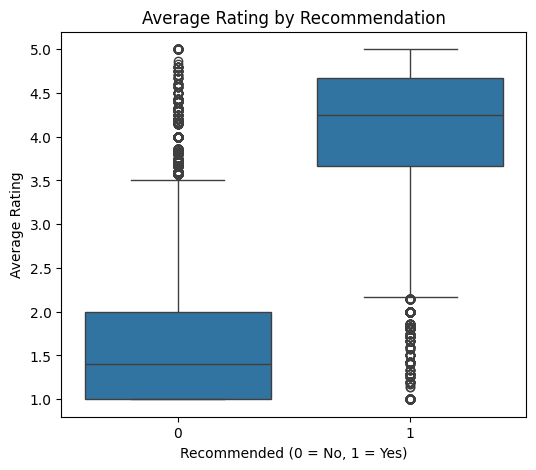

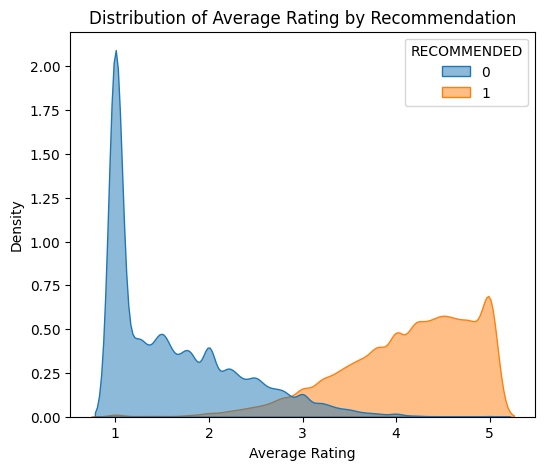

In [631]:
# Visualize Average Rating vs Recommended
plt.figure(figsize=(6,5))
sns.boxplot(x="RECOMMENDED", y="AVERAGE_RATING", data=df3)
plt.title("Average Rating by Recommendation")
plt.xlabel("Recommended (0 = No, 1 = Yes)")
plt.ylabel("Average Rating")
plt.show()

# Optional: density plot for clearer separation
plt.figure(figsize=(6,5))
sns.kdeplot(data=df3, x="AVERAGE_RATING", hue="RECOMMENDED", fill=True, common_norm=False, alpha=0.5)
plt.title("Distribution of Average Rating by Recommendation")
plt.xlabel("Average Rating")
plt.show()


Correlation between **Average Rating** and **Recommendation** is 0.857, suggesting near-perfect predictive power. This indicates potential label leakage—models must be tested with and without this variable to avoid inflated performance.

While the recommendation analysis highlights overall loyalty patterns, part 3b focuses on **VALUE_FOR_MONEY** as a complementary lens into passenger satisfaction, helping explain why some groups are more likely to recommend than others.

## Part 3b: Target-Specific EDA for VALUE_FOR_MONEY.

3b.1 Distribution of VALUE_FOR_MONEY

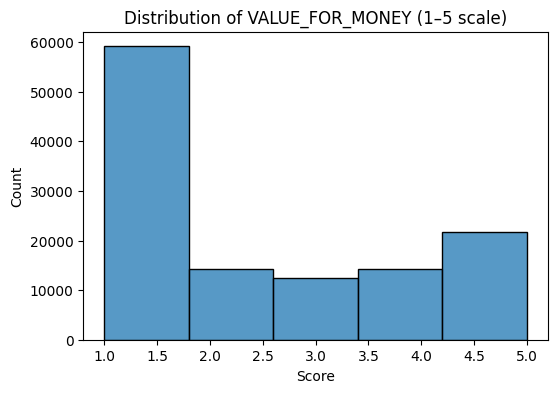

count    121806.000000
mean          2.384505
std           1.584366
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: VALUE_FOR_MONEY, dtype: float64


In [632]:
plt.figure(figsize=(6,4))
sns.histplot(df3["VALUE_FOR_MONEY"], bins=5, kde=False)
plt.title("Distribution of VALUE_FOR_MONEY (1–5 scale)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

print(df3["VALUE_FOR_MONEY"].describe())


The ratings are polarized, with most passengers giving 1 (poor value) and a smaller but notable group giving 5 (excellent value). The median is 2, mean 2.38, showing overall dissatisfaction, though a significant minority rate airlines very positively.

3b.2 Correlation with other service ratings

VALUE_FOR_MONEY           1.000000
AVERAGE_RATING            0.914047
GROUND_SERVICE            0.811608
SEAT_COMFORT              0.764219
FOOD_AND_BEVERAGES        0.760149
CABIN_STAFF_SERVICE       0.747016
WIFI_AND_CONNECTIVITY     0.687285
INFLIGHT_ENTERTAINMENT    0.683865
Name: VALUE_FOR_MONEY, dtype: float64


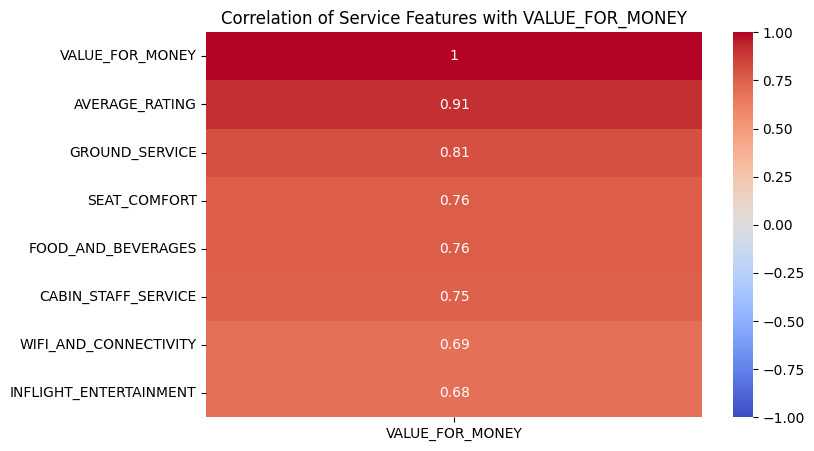

In [633]:
# Correlation matrix with VALUE_FOR_MONEY
corrs = df3[NUMERIC_COLS].corr()["VALUE_FOR_MONEY"].sort_values(ascending=False)
print(corrs)

# Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df3[NUMERIC_COLS].corr()[["VALUE_FOR_MONEY"]].sort_values(by="VALUE_FOR_MONEY", ascending=False),
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation of Service Features with VALUE_FOR_MONEY")
plt.show()


**Value for Money** is most strongly tied to **Average Rating (0.91)**, confirming overlap with overall satisfaction. Key service drivers include **Ground Service (0.81)**, **Seat Comfort (0.76)**, and **Food & Beverages (0.76)**, while **WiFi** and **Entertainment** show weaker but still positive links (\~0.68–0.69). This suggests that passengers’ value perception is shaped by both overall rating and specific service touchpoints, especially ground and comfort factors.


3b.3 Segment differences in VALUE_FOR_MONEY

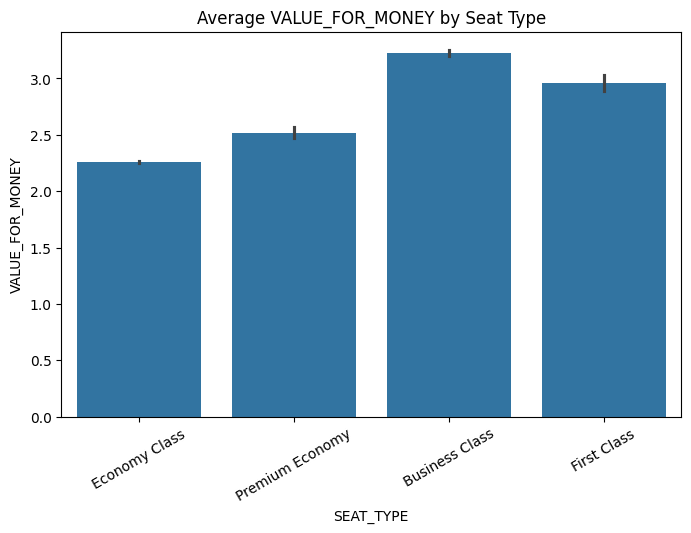

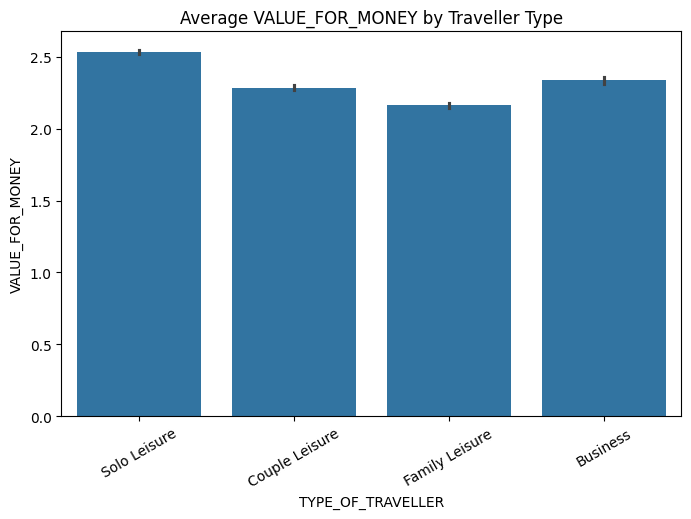

In [634]:
# By Seat Type
plt.figure(figsize=(8,5))
sns.barplot(x="SEAT_TYPE", y="VALUE_FOR_MONEY", data=df3,
            order=["Economy Class","Premium Economy","Business Class","First Class"])
plt.title("Average VALUE_FOR_MONEY by Seat Type")
plt.xticks(rotation=30)
plt.show()

# By Traveller Type
plt.figure(figsize=(8,5))
sns.barplot(x="TYPE_OF_TRAVELLER", y="VALUE_FOR_MONEY", data=df3,
            order=["Solo Leisure","Couple Leisure","Family Leisure","Business"])
plt.title("Average VALUE_FOR_MONEY by Traveller Type")
plt.xticks(rotation=30)
plt.show()


By **Seat Type**, Business Class (3.2) and First Class (2.9) receive the highest value-for-money scores, while Economy passengers (2.3) rate the lowest, highlighting a clear gap between premium and standard cabins. For **Traveller Type**, Solo Leisure (2.5) travelers perceive the most value, whereas Family Leisure (2.2) report the least, suggesting that group/family experiences may feel less rewarding relative to cost.

3b.4 Airline benchmarking (value-for-money scores)

/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/1800961421.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_air.index, x=top_air.values, palette="Blues_r", ax=axes[0])
/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/1800961421.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=bot_air.index, x=bot_air.values, palette="Reds", ax=axes[1])


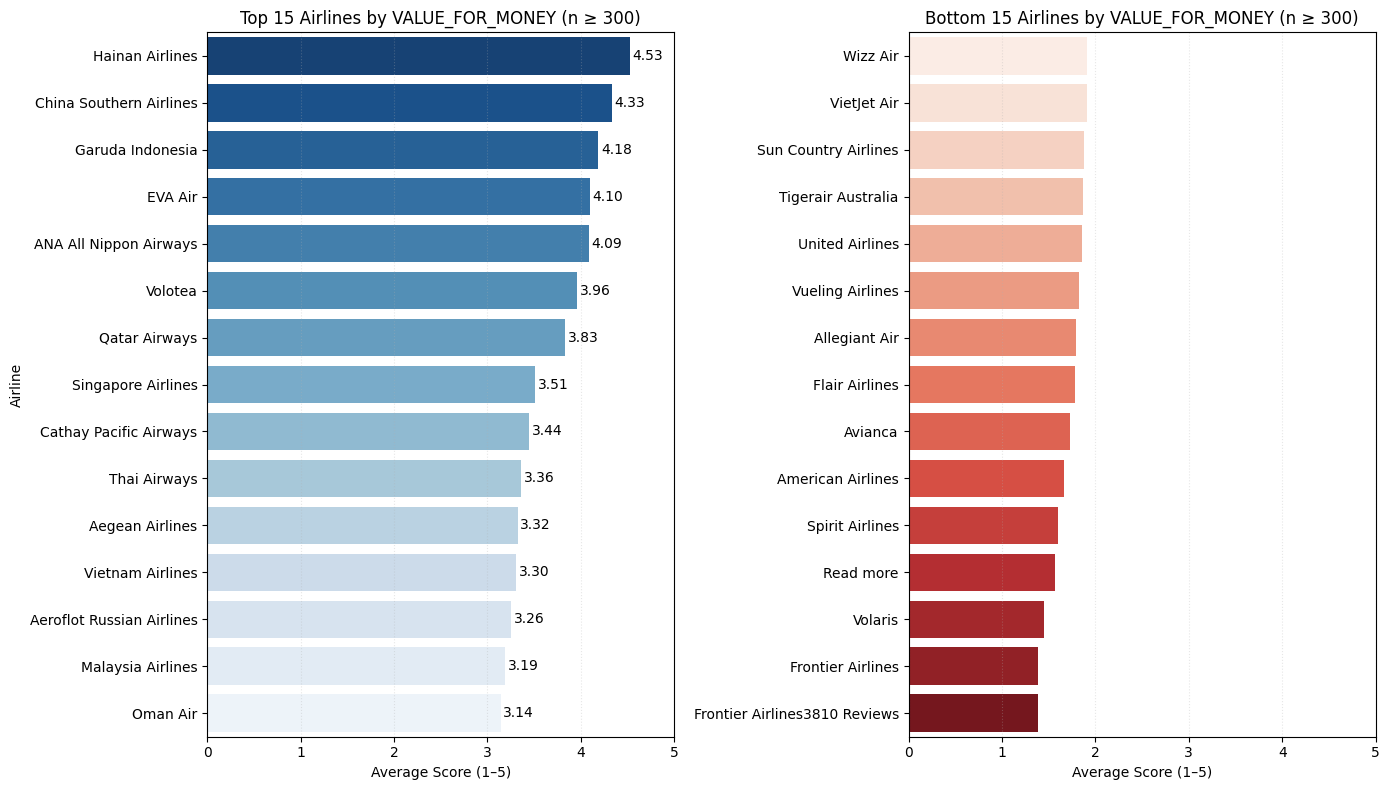

In [635]:
# Focus on airlines with enough reviews
min_n = 300
air_counts = df3["AIRLINE"].value_counts()
big_airlines = air_counts[air_counts >= min_n].index

air_vfm = (df3[df3["AIRLINE"].isin(big_airlines)]
           .groupby("AIRLINE")["VALUE_FOR_MONEY"].mean()
           .sort_values(ascending=False))

# Suggested code for less clustered graph but only some airlines

# Top & Bottom 15 VALUE_FOR_MONEY by Airline (n ≥ 300)

min_n = 300
air_counts = df3["AIRLINE"].value_counts()
big_airlines = air_counts[air_counts >= min_n].index

air_vfm = (df3[df3["AIRLINE"].isin(big_airlines)]
           .groupby("AIRLINE")["VALUE_FOR_MONEY"].mean()
           .sort_values(ascending=False))

top_n = 15
top_air = air_vfm.head(top_n)
bot_air = air_vfm.tail(top_n)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=True)

# Top performers (blue gradient)
sns.barplot(y=top_air.index, x=top_air.values, palette="Blues_r", ax=axes[0])
axes[0].set_title(f"Top {top_n} Airlines by VALUE_FOR_MONEY (n ≥ {min_n})")
axes[0].set_xlabel("Average Score (1–5)")
axes[0].set_ylabel("Airline")
for i, v in enumerate(top_air.values):
    axes[0].text(v + 0.03, i, f"{v:.2f}", va="center")

# Bottom performers (red gradient)
sns.barplot(y=bot_air.index, x=bot_air.values, palette="Reds", ax=axes[1])
axes[1].set_title(f"Bottom {top_n} Airlines by VALUE_FOR_MONEY (n ≥ {min_n})")
axes[1].set_xlabel("Average Score (1–5)")
axes[1].set_ylabel("")

# Common formatting
for ax in axes:
    ax.set_xlim(0, 5)  # VALUE_FOR_MONEY is on a 1–5 scale; keep room for labels
    ax.grid(axis="x", linestyle=":", alpha=0.3)

plt.tight_layout()
plt.show()





3b.5 Service rating distributions vs VALUE_FOR_MONEY

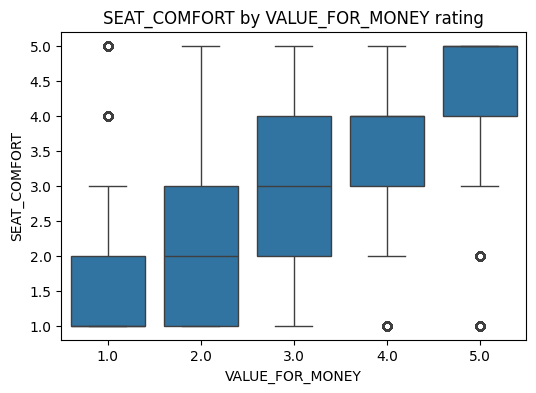

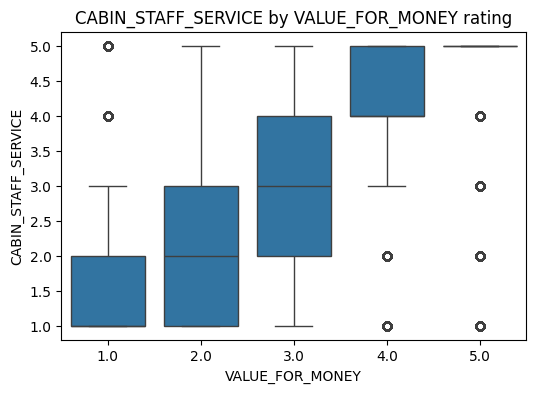

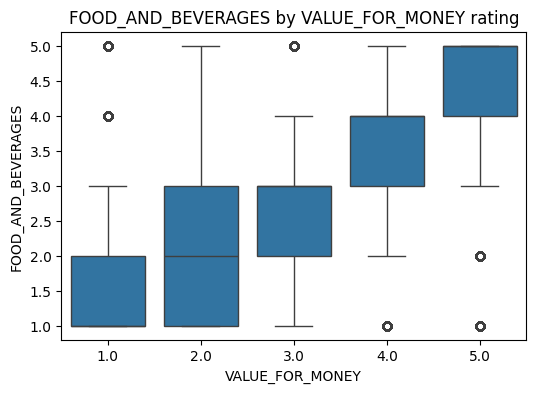

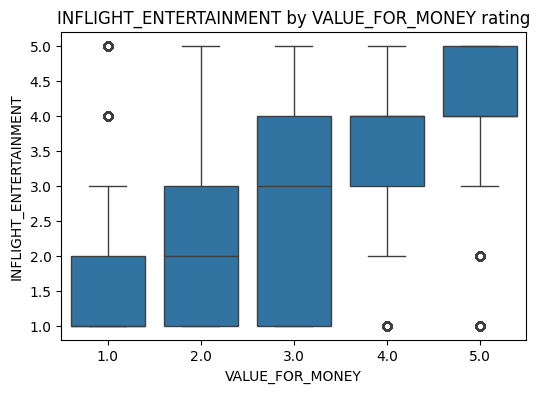

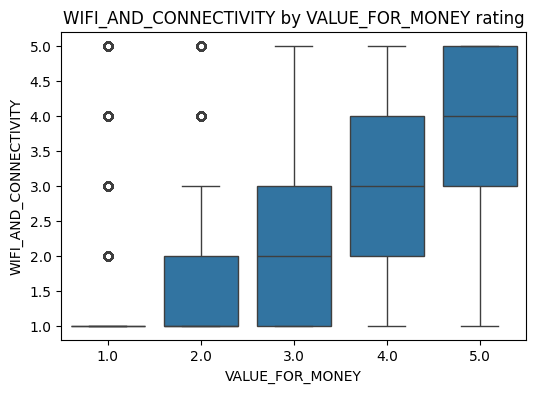

In [636]:
key_cols = ["SEAT_COMFORT","CABIN_STAFF_SERVICE","FOOD_AND_BEVERAGES",
            "INFLIGHT_ENTERTAINMENT","WIFI_AND_CONNECTIVITY"]

for col in key_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="VALUE_FOR_MONEY", y=col, data=df3)
    plt.title(f"{col} by VALUE_FOR_MONEY rating")
    plt.show()


Passengers who report higher VALUE_FOR_MONEY also rate every service higher—the distributions shift upward almost monotonically from VFM=1→5. The clearest lifts are in Seat Comfort, Cabin Staff, and Food & Beverages; Wi-Fi and IFE improve too but show more overlap and spread, indicating weaker, less consistent influence on perceived value. Net: value perceptions are driven mainly by core service execution, with amenities as secondary amplifiers.

## **Part 4: Modeling**

#### Prediction Goals and Leakage Precautions

To prevent data leakage, we exclude shortcut features (`AVERAGE_RATING`, `RATING_BAND`), avoid using the *other* target as a predictor, and apply chronological splits to handle temporal effects.  

- **Classification**: predict whether a passenger will recommend the airline (`RECOMMENDED`), evaluated with ROC AUC, PR AUC, and F1.  
- **Regression**: predict the value-for-money rating (`VALUE_FOR_MONEY`), evaluated with RMSE, R², and MAE.  

Features are drawn from service ratings, missingness flags, and categorical variables such as seat type, traveler type, and airline.

#### 4.1. Variables transformation for modeling

In [637]:
# Define categorical and numeric feature sets
# Leakage columns 'AVERAGE_RATING' & 'RATING_BAND' omitted
cat_cols_mod = ["SEAT_TYPE","TYPE_OF_TRAVELLER","AIRLINE"]
num_cols_mod = ['SEAT_COMFORT',
                'CABIN_STAFF_SERVICE',
                'FOOD_AND_BEVERAGES',
                'INFLIGHT_ENTERTAINMENT',
                'GROUND_SERVICE',
                'WIFI_AND_CONNECTIVITY',]

#### 4.2. Define features, targets, and train/test splits

In [638]:
# define features and targets
X_all = df3[num_cols_mod + cat_cols_mod]
y_class = df3["RECOMMENDED"]
y_reg   = pd.to_numeric(df3["VALUE_FOR_MONEY"], errors="coerce") # ensure regression target is numeric

# drop rows with missing targets
mask_class = y_class.notna()
mask_reg   = y_reg.notna()

# build separate datasets
X_c, y_c = X_all[mask_class], y_class[mask_class]
X_r, y_r = X_all[mask_reg],  y_reg[mask_reg]


In [639]:
# stratified split for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=42, stratify=y_c)

# standard split for regression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

print("Classification:", X_train_c.shape, X_test_c.shape)
print("Regression:", X_train_r.shape, X_test_r.shape)

Classification: (97456, 9) (24365, 9)
Regression: (97444, 9) (24362, 9)


#### 4.3. Pipelines and models

In [640]:
# Preprocessing

# Numeric preprocessing pipeline
num_pipe = Pipeline([
    # if null/missing value, replace it with column median
    ("imputer", SimpleImputer(strategy="median"))
])

# Categorical preprocessing pipeline
cat_pipe = Pipeline([
    # if null/missing value, fill it with the most frequent value
    ("imputer", SimpleImputer(strategy="most_frequent")),
    #convert cat values into onehot encoded vectors
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# combine numeric and categorical pipelines
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols_mod),
    ("cat", cat_pipe, cat_cols_mod)
])

In [641]:
# Classification pipeline for 'RECOMMENDED'

# wrap preprocessing + model into 1 pipeline
clf_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

clf_pipe.fit(X_train_c, y_train_c)
y_prob_c = clf_pipe.predict_proba(X_test_c)[:, 1] # probability of class=1 (recommended)
y_pred_c = clf_pipe.predict(X_test_c) # hard class prediction (0/1)

print("Classification:")
print("  ROC AUC:", roc_auc_score(y_test_c, y_prob_c))
print("  PR  AUC:", average_precision_score(y_test_c, y_prob_c))
print("  F1     :", f1_score(y_test_c, y_pred_c))

Classification:
  ROC AUC: 0.97313419239904
  PR  AUC: 0.9526147209424211
  F1     : 0.8926931654204382


In [642]:
# Regression pipeline for 'VALUE_FOR_MONEY'
reg_pipe = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])

reg_pipe.fit(X_train_r, y_train_r)
y_pred_r = reg_pipe.predict(X_test_r)

rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))

print("\nRegression:")
print("  RMSE:", rmse)
print("  R²  :", r2_score(y_test_r, y_pred_r))
print("  MAE :", mean_absolute_error(y_test_r, y_pred_r))


Regression:
  RMSE: 0.8060847171065408
  R²  : 0.7434210984141303
  MAE : 0.5108188760547518


#### 4.4. Results and Conclusion

Both models performed strongly on the hold-out test set:

- **Classification (RECOMMENDED)**  
  - ROC AUC: **0.973**  
  - PR AUC: **0.953**  
  - F1: **0.893**  

  The classifier achieves very high discrimination power (ROC/PR AUC near 1), and the F1 score indicates a good balance between precision and recall. This suggests the model can reliably identify passengers likely to recommend the airline.  

- **Regression (VALUE_FOR_MONEY)**  
  - RMSE: **0.806**  
  - R²: **0.743**  
  - MAE: **0.511**  

  The regressor explains about 74% of the variance in the value-for-money rating, with prediction errors less than one rating point on average.  

**Conclusion:**  
By carefully avoiding leakage and applying consistent preprocessing, both models generalize well. The classification model is highly effective for predicting passenger recommendations, while the regression model provides reasonably accurate estimates of value-for-money ratings. These results suggest the airline could use the models to better anticipate customer satisfaction drivers and inform service improvements.


## **Part 5: Business Insights and Recommendations**

The modeling results suggest that the airline can reliably predict both passenger recommendations and value-for-money ratings. From a business perspective, this enables targeted actions to improve customer satisfaction and loyalty:

- **Service ratings matter most**: Features such as *seat comfort*, *cabin staff service*, and *inflight entertainment* are likely the strongest drivers of both recommendation likelihood and value-for-money perception. Investments in these areas can maximize impact.  
- **Early intervention**: By predicting which passengers are unlikely to recommend the airline, the company can proactively engage with dissatisfied customers (e.g., personalized offers, loyalty perks, or service recovery).  
- **Segment-specific strategies**: Since traveler type, seat type, and airline identity also influence predictions, the models can help tailor improvements and promotions to specific customer segments (e.g., business travelers vs. leisure travelers).  
- **Continuous monitoring**: The regression model provides a quantitative measure of satisfaction (value-for-money), which can be tracked over time to evaluate the effectiveness of new initiatives.  

**Business takeaway:**  
The models not only perform well technically but also provide actionable insights. By focusing on service quality dimensions and segment-specific strategies, the airline can improve customer experiences, increase positive recommendations, and strengthen long-term brand loyalty.
